# 16S Diversity Analyses

In [1]:
import pandas as pd
import numpy as np
from utils.utils import confidence_ellipse , save_fna
from zipfile import ZipFile
from IPython.display import HTML

#Qiime
import qiime2 as q2
from qiime2.plugins.diversity.actions import alpha
from qiime2.plugins.diversity.actions import beta
from qiime2.plugins.feature_table.actions import rarefy
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 
from qiime2.plugins.qurro.actions import differential_plot
from qiime2.plugins.taxa.actions import collapse 
from biom import Table, load_table

#Stats
from scipy.stats import sem
from skbio import OrdinationResults
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from scipy import stats

#Plotting
import plotnine as pn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
def get_q2(file):
    """Given path to model_fit.qzv, returns q2 score"""
    with ZipFile(file, 'r') as z:
        index_file=[x for x in z.namelist() if "index.html" in x][0]
        with z.open(index_file) as f:
            q2=f.readlines()[3].split()[-1].decode("utf-8") .replace("</p>",'')
            return(q2)
        
def top_bottom(x):
    r1 = [i for i in range(x)]
    r2=[-i for i in range(1,x+1)]
    r2.reverse()
    return(r1+r2)

def shorten_taxon(taxon):
    temp=taxon.split(";")
    out = ''
    for i in [-x for x in range(1,len(temp))]:
        if i==-1:
            out = temp[i]
        elif len(temp[i]) > 4:
            out = temp[i] + ";" + out
            return(out)
        else:
            out = temp[i] + ";" + out
        

    return(out)

def get_top_list(sbd, abx, sample_type, factor, i):
    temp_df = sbd[sample_type][abx]["differentials"].view(pd.DataFrame)
    temp_df = temp_df.sort_values(factor, ascending=False)
    temp_df_ss = temp_df.iloc[top_bottom(i)].copy()
    temp_df_ss["Genus"] = [shorten_taxon(x) for x in temp_df_ss.index]
    #temp_df_ss = temp_df_ss.loc[["mitochondria" not in x for x in temp_df_ss.Taxon]]
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Genus",factor ]]
    temp_df_ss.columns=["Genus","Differential"]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)


def get_increasing_list(sbd, abx, sample_type, factor, i):
    temp_df = sbd[sample_type][abx]["differentials"].view(pd.DataFrame)
    temp_df = temp_df.sort_values(factor, ascending=False)
    temp_df_ss = temp_df.iloc[range(i)].copy()
    temp_df_ss["Genus"] = [shorten_taxon(x) for x in temp_df_ss.index]
    #temp_df_ss = temp_df_ss.loc[["mitochondria" not in x for x in temp_df_ss.Taxon]]
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Genus",factor ]]
    temp_df_ss.columns=["Genus","Songbird Differential"]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)

def get_decreasing_list(sbd, abx, sample_type, factor, i):
    temp_df = sbd[sample_type][abx]["differentials"].view(pd.DataFrame)
    temp_df = temp_df.sort_values(factor, ascending=False)
    temp_df_ss = temp_df.iloc[[-x for x in range(1,i+1)]].copy()
    temp_df_ss["Genus"] = [shorten_taxon(x) for x in temp_df_ss.index]
    #temp_df_ss = temp_df_ss.loc[["mitochondria" not in x for x in temp_df_ss.Taxon]]
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Genus",factor ]]
    temp_df_ss.columns=["Genus","Songbird Differential"]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)



# Make phylogeny for Doty and Stillwell
Not sure which timepoints/samples we will end up using, so making phylogeny with all sequences from all samples. 
Not including Rhee in phylogeny

In [ ]:
#Import and merge all samples from doty and stillwell
data_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/raw_data/"
stillwell_bt = load_table(data_dir + "56431_reference-hit.biom")
doty_bt = load_table(data_dir + "56491_reference-hit.biom")
merged_bt = doty_bt.merge(stillwell_bt)

#Save fna and qza of all sequences from all samples in stillwell and doty
out_root="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/20200605_all_stody_seqs"
save_fna(bt=merged_bt, out_root=out_root)

In [1]:
%%script bash
echo '
#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /home/swandro/infant/logs
#PBS -o /home/swandro/infant/logs
#PBS -l walltime=24:00:00
#PBS -l nodes=1:ppn=16
#PBS -l mem=160gb
#PBS -N sepp_stody

source ~/.bash_profile
conda activate qiime2-2020.2

data_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/

qiime fragment-insertion sepp \
  --i-representative-sequences $data_dir/20200605_all_stody_seqs.qza \
  --i-reference-database /home/swandro/databases/sepp-refs-gg-13-8.qza \
  --o-tree $data_dir/stody_insertion_tree.qza \
  --o-placements $data_dir/stody_insertion_placements.qza


' | qsub

1345247.barnacle.ucsd.edu


# Classify sequences

In [18]:
%%script bash
echo '
#!/bin/bash -l
#PBS -m ae
#PBS -M swandro@ucsd.edu
#PBS -S /bin/bash
#PBS -e /home/swandro/infant/logs
#PBS -o /home/swandro/infant/logs
#PBS -l walltime=12:00:00
#PBS -l nodes=1:ppn=2
#PBS -l mem=24gb
#PBS -N 2classify_stody

source ~/.bash_profile
conda activate qiime2-2019.7

data_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/

qiime feature-classifier classify-sklearn \
  --i-reads $data_dir/all_stody_seqs.qza \
  --i-classifier ~/databases/gg-13-8-99-515-806-nb-classifier.qza \
  --o-classification $data_dir/stody_seq_classification.qza

' | qsub

1346372.barnacle.ucsd.edu


# Import data for diversity analyses

In [3]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
#Import biom
bac_bt = load_table(root_dir + "intermediate_data/20200611_filtered_16S_table.biom")
qza =  q2.Artifact.import_data('FeatureTable[Frequency]', bac_bt)

#Import metadata
md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t', index_col=0)

In [4]:
#Import taxonomy
tax_qza =  q2.Artifact.load(root_dir + "intermediate_data/stody_seq_classification.qza")
tax_md_qza = q2.Metadata(pd.DataFrame(tax_qza.view(pd.Series)))
tax_df = tax_qza.view(pd.DataFrame)

In [5]:
#Collapse to genus
genus_qza = collapse(table=qza, taxonomy=tax_qza, level=6).collapsed_table
genus_bt = genus_qza.view(Table)
#Filter out mitochondria
mito_taxa = [x for x in genus_bt.ids("observation") if "mitochondria" in x]
genus_bt.filter(mito_taxa, invert=True, axis="observation")

1154 x 942 <class 'biom.table.Table'> with 29528 nonzero entries (2% dense)

# Alpha diversity

Format and calculate Alpha

In [167]:
#Rarefy
rare_qza = rarefy(qza, 1250).rarefied_table

#Caluclate alpha
alpha_results_shannon = alpha(table = rare_qza, metric="shannon").alpha_diversity
alpha_df = alpha_results_shannon.view(pd.Series)
alpha_df = pd.DataFrame(alpha_df, columns=["shannon"])
alpha_df.index.name = "sample_name"
#Save table
alpha_df.to_csv(root_dir + "results/tables/20200605_alpha_shannon.tsv", sep='\t')

In [9]:
#Load table
alpha_df = pd.read_csv(root_dir + "results/tables/20200605_alpha_shannon.tsv", sep='\t', index_col=0)

Format for plotting

In [10]:
#Add alpha to metadata
alpha_plot_data = md.merge(alpha_df, right_index=True, left_index=True)
#Calculate mean and SEM
alpha_plot_data = alpha_plot_data.groupby(["study_delivery_mode","sample_type","abx012","age"]).agg({"shannon":["mean","sem"]})
alpha_plot_data = alpha_plot_data.reset_index()
alpha_plot_data.columns=["cohort","sample_type","abx","day","avg","err"]
#Order cohorts
cohorts = ["LP-Vaginal","LP-C-section","VLBW-Vaginal","VLBW-C-section"]
alpha_plot_data["cohort"] = pd.Categorical(alpha_plot_data.cohort, ordered=True, categories=cohorts)
#Make Abx label
alpha_plot_data.abx = alpha_plot_data.abx.astype(str)
alpha_plot_data.abx = alpha_plot_data.abx.replace({"1":"Infant Abx+","0":"No Abx","2":"Maternal Abx+"})
alpha_plot_data = alpha_plot_data.dropna()

alpha_plot_data["sample_type"] = pd.Categorical(alpha_plot_data.sample_type, categories=["Stool","Oral","Skin"])
alpha_plot_data["abx"] = pd.Categorical(alpha_plot_data.abx, categories=["No Abx","Infant Abx+","Maternal Abx+"])


Plot alpha

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/20200605_alpha_shannon.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/20200605_alpha_shannon.pdf
  warn('Filename: {}'.format(filename), PlotnineWar

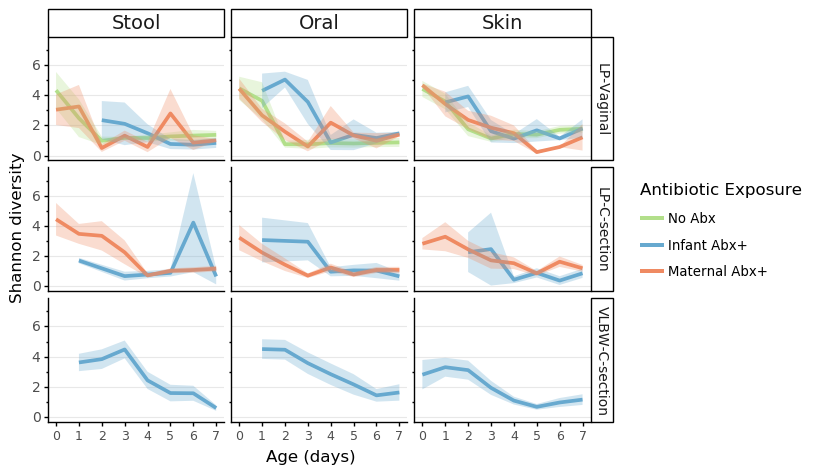

<ggplot: (8744858379170)>

In [18]:
#Plot
colors=['#b2df8a','#1f78b4','#a6cee3']
colors =["#b2df8a","#67a9cf","#ef8a62"]
pn.options.figure_size = (7,5)
p = (pn.ggplot(data=alpha_plot_data) +
    pn.geom_line( pn.aes( x="day", y="avg", group="abx", color="abx"), size=1.5) +
     pn.geom_ribbon( pn.aes( x="day", ymin="avg-err", ymax="avg+err", group="abx", fill="abx"), alpha=.3) +
    #pn.line( pn.aes( x="age", y="shannon", fill="abx_any_source"), size=3) +
     pn.scale_fill_manual(colors) +
     pn.scale_color_manual(colors) +
     pn.scale_x_continuous(limits=[0,7], breaks=[0,1,2,3,4,5,6,7]) +
     pn.facet_grid('cohort~sample_type') +
     pn.guides(fill=None) +
     pn.labs(x="Age (days)", y="Shannon diversity", color="Antibiotic Exposure\n") +
    pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey",alpha=.5),
             axis_ticks_minor_x = pn.element_blank(),
             axis_text_x = pn.element_text(size=9),
             axis_text_y = pn.element_text(size=10),
             strip_text_x=pn.element_text(size=14),
             strip_text_y=pn.element_text(size=10))
    )
p.save(root_dir + "results/figures/svg/20200605_alpha_shannon.svg", format="svg", dpi=300)
p.save(root_dir + "results/figures/20200605_alpha_shannon.pdf", dpi=300)
p

# Beta Diversity

Calculate rpca

In [171]:
#Calculate beta diversity
biplot, dm = rpca(table = qza,
                  n_components=3,
                 min_sample_count=500,
                 min_feature_count=10)
biplot.save(root_dir + "intermediate_data/20200605_stody_deicode_biplot.qza")
dm.save(root_dir + "intermediate_data/20200605_stody_deicode_dm.qza")

'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/20200605_stody_deicode_dm.qza'

In [78]:
# Calculate jaccard distance
jaccard_df = beta(table = qza, metric="jaccard").distance_matrix.view(DistanceMatrix).to_data_frame()
jaccard_df.to_csv(root_dir + "intermediate_data/16_jaccard_distances.tsv", sep='\t')

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Or load previously calculated rpca

In [8]:
biplot = q2.Artifact.load(root_dir + "intermediate_data/20200605_stody_deicode_biplot.qza")
dm = q2.Artifact.load(root_dir + "intermediate_data/20200605_stody_deicode_dm.qza")
jaccard_df = pd.read_csv(root_dir + "intermediate_data/16_jaccard_distances.tsv", sep='\t', index_col=0)

Make ordination

Without maternal antibiotics

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/utils.py:49: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)


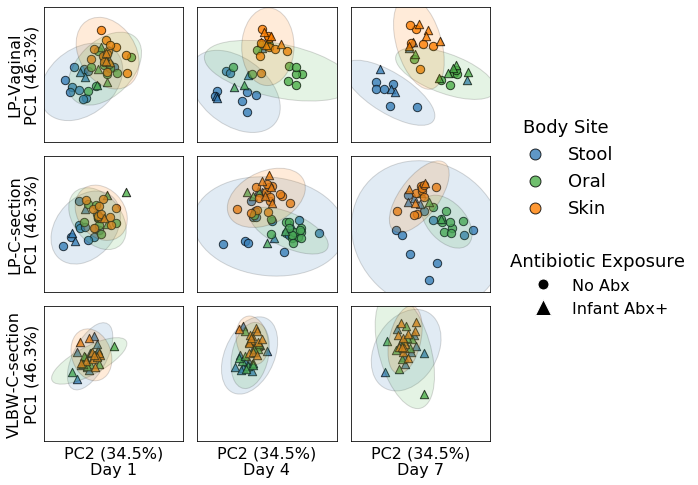

In [17]:
ordination = biplot.view(OrdinationResults)
ordinaiton_samples = ordination.samples
ordinaiton_samples.columns = ["Axis1","Axis2","Axis3"]
ordination_variances = ordination.proportion_explained
ordinaiton_samples = ordinaiton_samples.merge(md, right_index=True, left_index=True)
plot_variances = {"PC1":round(ordination_variances[0]*100,1),"PC2":round(ordination_variances[1]*100,1)}

#Axis boundaries
buffer=.02
xmax = ordinaiton_samples.Axis1.max() + buffer
xmin = ordinaiton_samples.Axis1.min() - buffer
ymax = ordinaiton_samples.Axis2.max() + buffer
ymin = ordinaiton_samples.Axis2.min() - buffer

days = [1,4,7]
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
sample_types = ["Stool","Oral","Skin"]
colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
color_dict = {x:y for x,y in zip(sample_types,colors)}

abx_list = [0,1]
shape_list = ["o","^"]
#["#d55e00","#0072b2""#009e73"]
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,8))
fig.subplots_adjust(wspace=0.1, hspace=.1)
for i in range(len(cohorts)):
    for j in range(len(days)):
        for C in sample_types:
            for ab in range(len(abx_list)):
                #data_subset = ordinaiton_samples.loc[ (deicode_ord["study_delivery_mode"] == cohorts[i]) & (deicode_ord["age"] == days[j]) & (deicode_ord["sample_type"] == C) & (deicode_ord.abx_any_source == abx_list[ab])]
                data_subset = ordinaiton_samples.query('study_delivery_mode==@cohorts[@i] & age==@days[@j] & sample_type==@C & metadata_abx==@abx_list[@ab]')
                x= data_subset.Axis1
                y= data_subset.Axis2
                
                if i==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], alpha=.15,edgecolor= "black" )
                if i==1 and ab==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                if ab==0:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                else:
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=None, edgecolors="black", linewidth=1)
                
                #axs[i,j].legend()
        axs[i,j].set_ylim([ymin,ymax])
        axs[i,j].set_xlim([xmin,xmax])
        if i == 2 :
            axs[i,j].set_xlabel("PC2 ({}%)\n".format(plot_variances["PC2"]) + "Day " + str(days[j]) , size=16)
        if j==0:
            axs[i,j].set_ylabel(cohorts[i] + "\nPC1 ({}%)".format(plot_variances["PC1"]), size=16)
        #remove axis text and ticks
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
#Abx legend
point = Line2D([0], [0], marker='.', color='w', label='Scatter', markerfacecolor='black', markersize=22)
star = Line2D([0], [0], marker='^', color='w', label='Scatter', markerfacecolor='black', markersize=16)
dia = Line2D([0], [0], marker='D', color='w', label='Scatter', markerfacecolor='black', markersize=12)
leg1 = plt.legend([point,star,dia],['No Abx','Infant Abx+'], 
                  bbox_to_anchor=(2.50, 1.5), loc='upper right', ncol=1,fontsize=14,frameon=False,prop={'size': 16},
                  title="Antibiotic Exposure", title_fontsize=18)
lgd =plt.legend(loc='upper right',bbox_to_anchor=[2.0, 2.5], ncol=1, 
                fontsize=14,frameon=False,prop={'size': 18}, title="Body Site", title_fontsize=18)
for handle in lgd.legendHandles:
    handle.set_sizes([120]) 
plt.gca().add_artist(leg1) 

#plt.tight_layout()
fig.savefig(root_dir + 'results/figures/svg/deicode_pcoa_grid.svg', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',pad_inches = 1, format="svg", dpi=300)
fig.savefig(root_dir + 'results/figures/deicode_pcoa_grid.pdf', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',pad_inches = 1, dpi=300)
plt.show()

With maternal antibiotics

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/utils.py:49: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)


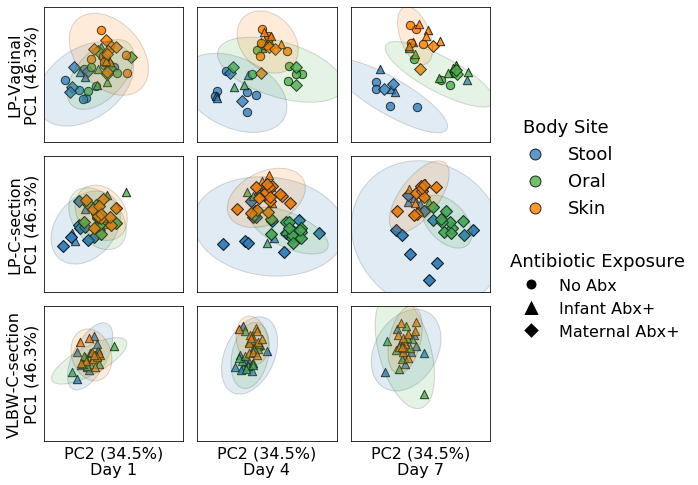

In [9]:
ordination = biplot.view(OrdinationResults)
ordinaiton_samples = ordination.samples
ordinaiton_samples.columns = ["Axis1","Axis2","Axis3"]
ordination_variances = ordination.proportion_explained
ordinaiton_samples = ordinaiton_samples.merge(md, right_index=True, left_index=True)
plot_variances = {"PC1":round(ordination_variances[0]*100,1),"PC2":round(ordination_variances[1]*100,1)}

#Axis boundaries
buffer=.02
xmax = ordinaiton_samples.Axis1.max() + buffer
xmin = ordinaiton_samples.Axis1.min() - buffer
ymax = ordinaiton_samples.Axis2.max() + buffer
ymin = ordinaiton_samples.Axis2.min() - buffer

days = [1,4,7]
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
sample_types = ["Stool","Oral","Skin"]
colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
color_dict = {x:y for x,y in zip(sample_types,colors)}

abx_list = [0,1,2]
shape_list = ["o","^","D"]
#["#d55e00","#0072b2""#009e73"]
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,8))
fig.subplots_adjust(wspace=0.1, hspace=.1)
for i in range(len(cohorts)):
    for j in range(len(days)):
        for C in sample_types:
            for ab in range(len(abx_list)):
                #data_subset = ordinaiton_samples.loc[ (deicode_ord["study_delivery_mode"] == cohorts[i]) & (deicode_ord["age"] == days[j]) & (deicode_ord["sample_type"] == C) & (deicode_ord.abx_any_source == abx_list[ab])]
                data_subset = ordinaiton_samples.query('study_delivery_mode==@cohorts[@i] & age==@days[@j] & sample_type==@C & abx012==@abx_list[@ab]')
                x= data_subset.Axis1
                y= data_subset.Axis2
                
                if i==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], alpha=.15,edgecolor= "black" )
                if i==1 and ab==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                if ab==0:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                else:
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=None, edgecolors="black", linewidth=1)
                
                #axs[i,j].legend()
        axs[i,j].set_ylim([ymin,ymax])
        axs[i,j].set_xlim([xmin,xmax])
        if i == 2 :
            axs[i,j].set_xlabel("PC2 ({}%)\n".format(plot_variances["PC2"]) + "Day " + str(days[j]) , size=16)
        if j==0:
            axs[i,j].set_ylabel(cohorts[i] + "\nPC1 ({}%)".format(plot_variances["PC1"]), size=16)
        #remove axis text and ticks
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
#Abx legend
point = Line2D([0], [0], marker='.', color='w', label='Scatter', markerfacecolor='black', markersize=22)
star = Line2D([0], [0], marker='^', color='w', label='Scatter', markerfacecolor='black', markersize=16)
dia = Line2D([0], [0], marker='D', color='w', label='Scatter', markerfacecolor='black', markersize=12)
leg1 = plt.legend([point,star,dia],['No Abx','Infant Abx+','Maternal Abx+'], 
                  bbox_to_anchor=(2.50, 1.5), loc='upper right', ncol=1,fontsize=14,frameon=False,prop={'size': 16},
                  title="Antibiotic Exposure", title_fontsize=18)
lgd =plt.legend(loc='upper right',bbox_to_anchor=[2.0, 2.5], ncol=1, 
                fontsize=14,frameon=False,prop={'size': 18}, title="Body Site", title_fontsize=18)
for handle in lgd.legendHandles:
    handle.set_sizes([120]) 
plt.gca().add_artist(leg1) 

#plt.tight_layout()
fig.savefig(root_dir + 'results/figures/svg/deicode_pcoa_grid_with_maternal_abx.svg', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',pad_inches = 1, format="svg", dpi=300)
fig.savefig(root_dir + 'results/figures/deicode_pcoa_grid_with_maternal_abx.pdf', bbox_extra_artists=(lgd,), 
            pad_inches = 1,bbox_inches='tight', dpi=300)
plt.show()

With metabolomically detected antibiotics

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/utils.py:49: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)


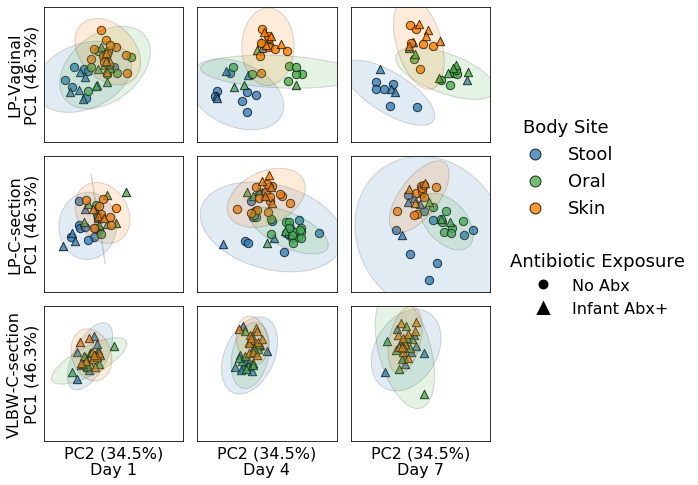

In [14]:
ordination = biplot.view(OrdinationResults)
ordinaiton_samples = ordination.samples
ordinaiton_samples.columns = ["Axis1","Axis2","Axis3"]
ordination_variances = ordination.proportion_explained
ordinaiton_samples = ordinaiton_samples.merge(md, right_index=True, left_index=True)
plot_variances = {"PC1":round(ordination_variances[0]*100,1),"PC2":round(ordination_variances[1]*100,1)}

#Axis boundaries
buffer=.02
xmax = ordinaiton_samples.Axis1.max() + buffer
xmin = ordinaiton_samples.Axis1.min() - buffer
ymax = ordinaiton_samples.Axis2.max() + buffer
ymin = ordinaiton_samples.Axis2.min() - buffer

days = [1,4,7]
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
sample_types = ["Stool","Oral","Skin"]
colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
color_dict = {x:y for x,y in zip(sample_types,colors)}

abx_list = [0,1]
shape_list = ["o","^"]
#["#d55e00","#0072b2""#009e73"]
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,8))
fig.subplots_adjust(wspace=0.1, hspace=.1)
for i in range(len(cohorts)):
    for j in range(len(days)):
        for C in sample_types:
            for ab in range(len(abx_list)):
                #data_subset = ordinaiton_samples.loc[ (deicode_ord["study_delivery_mode"] == cohorts[i]) & (deicode_ord["age"] == days[j]) & (deicode_ord["sample_type"] == C) & (deicode_ord.abx_any_source == abx_list[ab])]
                data_subset = ordinaiton_samples.query('study_delivery_mode==@cohorts[@i] & age==@days[@j] & sample_type==@C & abx_any_source==@abx_list[@ab]')
                x= data_subset.Axis1
                y= data_subset.Axis2
                
                if i==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], alpha=.15,edgecolor= "black" )
                if i==1 and ab==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                if ab==0:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                else:
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=None, edgecolors="black", linewidth=1)
                
                #axs[i,j].legend()
        axs[i,j].set_ylim([ymin,ymax])
        axs[i,j].set_xlim([xmin,xmax])
        if i == 2 :
            axs[i,j].set_xlabel("PC2 ({}%)\n".format(plot_variances["PC2"]) + "Day " + str(days[j]) , size=16)
        if j==0:
            axs[i,j].set_ylabel(cohorts[i] + "\nPC1 ({}%)".format(plot_variances["PC1"]), size=16)
        #remove axis text and ticks
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
#Abx legend
point = Line2D([0], [0], marker='.', color='w', label='Scatter', markerfacecolor='black', markersize=22)
star = Line2D([0], [0], marker='^', color='w', label='Scatter', markerfacecolor='black', markersize=16)
dia = Line2D([0], [0], marker='D', color='w', label='Scatter', markerfacecolor='black', markersize=12)
leg1 = plt.legend([point,star,dia],['No Abx','Infant Abx+'], 
                  bbox_to_anchor=(2.50, 1.5), loc='upper right', ncol=1,fontsize=14,frameon=False,prop={'size': 16},
                  title="Antibiotic Exposure", title_fontsize=18)
lgd =plt.legend(loc='upper right',bbox_to_anchor=[2.0, 2.5], ncol=1, 
                fontsize=14,frameon=False,prop={'size': 18}, title="Body Site", title_fontsize=18)
for handle in lgd.legendHandles:
    handle.set_sizes([120]) 
plt.gca().add_artist(leg1) 

#plt.tight_layout()
fig.savefig(root_dir + 'results/figures/svg/deicode_pcoa_grid_metabolomics_abx.svg', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',pad_inches = 1, format="svg", dpi=300)
fig.savefig(root_dir + 'results/figures/deicode_pcoa_grid_metabolomics_abx.pdf', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',pad_inches = 1, dpi=300)
plt.show()

_______

# PERMANOVA over time

Calculate PERMANOVAs

Without maternal antibiotics

In [58]:
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
days = set(md.age)
dm_df = dm.view(DistanceMatrix).to_data_frame()

out_list = []
for cohort in cohorts:
    for abx in [0.0, 1.0]:
        if cohort == "VLBW-C-section" and abx in [0.0,2.0]:
            continue
        for day in days:
            #Filter metadata
            md_ss = md.query('study_delivery_mode==@cohort & metadata_abx==@abx & age==@day')          
            ss_samples = set(md_ss.index)
            #Filter distance matrix
            dm_df_ss = dm_df.loc[[x in ss_samples for x in dm_df.index], [x in ss_samples for x in dm_df.columns]]
            #If any of the sample types has less than 4 samples, skip
            if any(md_ss.sample_type.value_counts() < 3) or md_ss.shape[0]==0:
                print("Skipping Cohort:{}, abx:{}, day:{}".format(cohort,abx,day))
                print([x for x in md_ss.sample_type.value_counts()])
                continue
            temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
            pm = permanova(distance_matrix=temp_dm, grouping=md_ss, column="sample_type")
            pm_df = pd.DataFrame(pm).transpose()
            pm_df["cohort"] = cohort
            pm_df["abx"] = abx
            pm_df["day"] = day
            out_list.append(pm_df)
perm_df = pd.concat(out_list)
#Add sgnificance bool
perm_df["sig"] = [x < 0.05 for x in perm_df["p-value"]]
perm_df["sig"] = ["p<0.05" if x==True else "p>0.05" for x in perm_df.sig]

#Save permanova
perm_df.to_csv(root_dir + "results/tables/16S_permanovas_over_time.txt", sep='\t', index=False)

Skipping Cohort:LP-Vaginal, abx:1.0, day:0.0
[]
Skipping Cohort:LP-Vaginal, abx:1.0, day:1.0
[4, 3, 2]
Skipping Cohort:LP-C-section, abx:1.0, day:0.0
[]
Skipping Cohort:LP-C-section, abx:1.0, day:1.0
[3, 3, 1]
Skipping Cohort:LP-C-section, abx:1.0, day:2.0
[3, 2, 2]
Skipping Cohort:LP-C-section, abx:1.0, day:3.0
[4, 3, 2]
Skipping Cohort:LP-C-section, abx:1.0, day:6.0
[3, 3, 2]
Skipping Cohort:VLBW-C-section, abx:1.0, day:0.0
[3, 1]


In [15]:
#Load permanova table
perm_df = pd.read_csv(root_dir + "results/tables/16S_permanovas_over_time.txt", sep='\t')

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/16S_deicode_permF_over_time.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/16S_deicode_permF_over_time.pdf
  warn('Filename: {}'.format(file

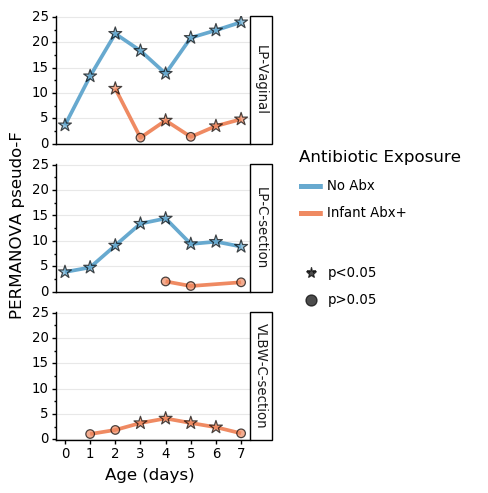

<ggplot: (8744853339084)>

In [16]:
pn.options.figure_size = (2.5,5.5)
plot_dat = perm_df.copy()
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
plot_dat["cohort"] = pd.Categorical(plot_dat.cohort, ordered=True, categories=cohorts)
plot_dat["value"] = [float(x) for x in plot_dat["test statistic"]]
abx_dict = {0.0: "No Abx",
           1.0: "Infant Abx+"}
plot_dat["abx"] = pd.Categorical([abx_dict[x] for x in plot_dat["abx"]], categories=["No Abx","Infant Abx+"])
plot_dat = plot_dat.query('day in [0,1,2,3,4,5,6,7]')

colors=["#67a9cf","#ef8a62","#b2df8a"]
#colors=['#b2df8a','#1f78b4','#a6cee3']

p = (pn.ggplot(data=plot_dat) +
    pn.geom_line( pn.aes( x="day", y="value", color="abx"), size=1.5) +
    pn.geom_point( pn.aes( x="day", y="value", fill="abx", shape="sig", size="sig"), alpha=.7) +
     pn.scale_size_manual([5,3]) +
     pn.scale_fill_manual(colors) +
     pn.scale_color_manual(colors) +
     pn.scale_shape_manual( values=["*","o"]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.facet_grid('cohort~.') +
     pn.guides( color=pn.guide_legend(override_aes={"size":2}),
               size=None,
              fill =None,
              shape = pn.guide_legend(override_aes={"size":4})) +
     pn.labs(x="Age (days)", y="PERMANOVA pseudo-F", color="Antibiotic Exposure\n", shape="") +
    pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey",alpha=.5),
             axis_ticks_minor_x = pn.element_blank(),
             axis_text = pn.element_text(color="black"),
             panel_spacing = .2)
    )
p.save(root_dir + "results/figures/svg/16S_deicode_permF_over_time.svg",dpi=300)
p.save(root_dir + "results/figures/16S_deicode_permF_over_time.pdf", dpi=300)
p

With maternal antibiotics

In [19]:
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
days = set(md.age)
dm_df = dm.view(DistanceMatrix).to_data_frame()

out_list_mabx = []
for cohort in cohorts:
    for abx in [0.0, 1.0,2.0]:
        if cohort == "VLBW-C-section" and abx in [0.0,2.0]:
            continue
        if cohort=="LP-C-section" and abx == 0.0:
            continue
        for day in days:
            #Filter metadata
            md_ss = md.query('study_delivery_mode==@cohort & abx012==@abx & age==@day')          
            ss_samples = set(md_ss.index)
            #Filter distance matrix
            dm_df_ss = dm_df.loc[[x in ss_samples for x in dm_df.index], [x in ss_samples for x in dm_df.columns]]
            #If any of the sample types has less than 4 samples, skip
            if any(md_ss.sample_type.value_counts() < 3) or md_ss.shape[0]==0:
                print("Skipping Cohort:{}, abx:{}, day:{}".format(cohort,abx,day))
                print([x for x in md_ss.sample_type.value_counts()])
                continue
            temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
            pm = permanova(distance_matrix=temp_dm, grouping=md_ss, column="sample_type")
            pm_df = pd.DataFrame(pm).transpose()
            pm_df["cohort"] = cohort
            pm_df["abx"] = abx
            pm_df["day"] = day
            out_list_mabx.append(pm_df)
perm_df_mabx = pd.concat(out_list_mabx)
#Add sgnificance bool
perm_df_mabx["sig"] = [x < 0.05 for x in perm_df_mabx["p-value"]]
perm_df_mabx["sig"] = ["p<0.05" if x==True else "p>0.05" for x in perm_df_mabx.sig]

#Save permanova
perm_df_mabx.to_csv(root_dir + "results/tables/16S_permanovas_over_time_maternal_abx.txt", sep='\t', index=False)

Skipping Cohort:LP-Vaginal, abx:1.0, day:0.0
[]
Skipping Cohort:LP-Vaginal, abx:1.0, day:1.0
[4, 3, 2]
Skipping Cohort:LP-Vaginal, abx:2.0, day:4.0
[3, 3, 2]
Skipping Cohort:LP-Vaginal, abx:2.0, day:6.0
[2, 2, 2]
Skipping Cohort:LP-Vaginal, abx:2.0, day:7.0
[2, 2, 2]
Skipping Cohort:LP-C-section, abx:1.0, day:0.0
[]
Skipping Cohort:LP-C-section, abx:1.0, day:1.0
[3, 3, 1]
Skipping Cohort:LP-C-section, abx:1.0, day:2.0
[3, 2, 2]
Skipping Cohort:LP-C-section, abx:1.0, day:3.0
[4, 3, 2]
Skipping Cohort:LP-C-section, abx:1.0, day:6.0
[3, 3, 2]
Skipping Cohort:VLBW-C-section, abx:1.0, day:0.0
[3, 1]


In [15]:
#Load permanova table
perm_df_mabx = pd.read_csv(root_dir + "results/tables/16S_permanovas_over_time_maternal_abx.txt", sep='\t')

Plot

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/16S_deicode_permF_over_time_maternal_abx.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/16S_deicode_permF_over_time_maternal_abx.pdf
  warn('Fil

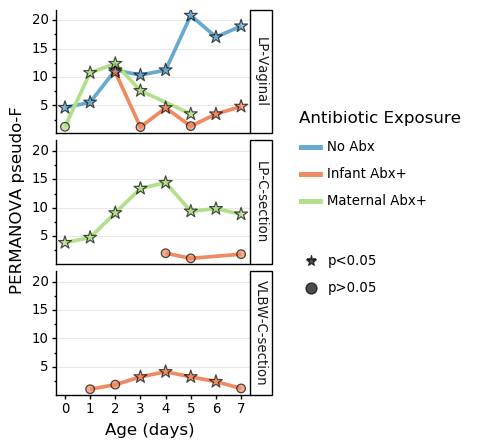

<ggplot: (-9223363281206402409)>

In [22]:
pn.options.figure_size = (2.5,5)
plot_dat = perm_df_mabx.copy()
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
plot_dat["cohort"] = pd.Categorical(plot_dat.cohort, ordered=True, categories=cohorts)
plot_dat["value"] = [float(x) for x in plot_dat["test statistic"]]
abx_dict = {0.0: "No Abx",
           1.0: "Infant Abx+",
           2.0:"Maternal Abx+"}
plot_dat["abx"] = pd.Categorical([abx_dict[x] for x in plot_dat["abx"]], categories=["No Abx","Infant Abx+","Maternal Abx+"])
plot_dat = plot_dat.query('day in [0,1,2,3,4,5,6,7]')

colors=["#67a9cf","#ef8a62","#b2df8a"]
#colors=['#b2df8a','#1f78b4','#a6cee3']

p = (pn.ggplot(data=plot_dat) +
    pn.geom_line( pn.aes( x="day", y="value", color="abx"), size=1.5) +
    pn.geom_point( pn.aes( x="day", y="value", fill="abx", shape="sig", size="sig"), alpha=.7) +
     pn.scale_size_manual([5,3]) +
     pn.scale_fill_manual(colors) +
     pn.scale_color_manual(colors) +
     pn.scale_shape_manual( values=["*","o"]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.facet_grid('cohort~.') +
     pn.guides( color=pn.guide_legend(override_aes={"size":2}),
               size=None,
              fill =None,
              shape = pn.guide_legend(override_aes={"size":4})) +
     pn.labs(x="Age (days)", y="PERMANOVA pseudo-F", color="Antibiotic Exposure\n", shape="") +
    pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey",alpha=.5),
             axis_ticks_minor_x = pn.element_blank(),
             axis_text = pn.element_text(color="black"))
    )
p.save(root_dir + "results/figures/svg/16S_deicode_permF_over_time_maternal_abx.svg", dpi=300)
p.save(root_dir + "results/figures/16S_deicode_permF_over_time_maternal_abx.pdf", dpi=300)
p

With metadata detected antibiotics

In [23]:
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
days = set(md.age)
dm_df = dm.view(DistanceMatrix).to_data_frame()

out_list_mabx = []
for cohort in cohorts:
    for abx in [0.0, 1.0]:
        if cohort == "VLBW-C-section" and abx in [0.0]:
            continue
        for day in days:
            #Filter metadata
            md_ss = md.query('study_delivery_mode==@cohort & abx_any_source==@abx & age==@day')          
            ss_samples = set(md_ss.index)
            #Filter distance matrix
            dm_df_ss = dm_df.loc[[x in ss_samples for x in dm_df.index], [x in ss_samples for x in dm_df.columns]]
            #If any of the sample types has less than 4 samples, skip
            if any(md_ss.sample_type.value_counts() < 3) or md_ss.shape[0]==0:
                print("Skipping Cohort:{}, abx:{}, day:{}".format(cohort,abx,day))
                print([x for x in md_ss.sample_type.value_counts()])
                continue
            temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
            pm = permanova(distance_matrix=temp_dm, grouping=md_ss, column="sample_type")
            pm_df = pd.DataFrame(pm).transpose()
            pm_df["cohort"] = cohort
            pm_df["abx"] = abx
            pm_df["day"] = day
            out_list_mabx.append(pm_df)
perm_df_mbx_abx = pd.concat(out_list_mabx)
#Add sgnificance bool
perm_df_mbx_abx["sig"] = [x < 0.05 for x in perm_df_mbx_abx["p-value"]]
perm_df_mbx_abx["sig"] = ["p<0.05" if x==True else "p>0.05" for x in perm_df_mbx_abx.sig]

#Save permanova
perm_df_mbx_abx.to_csv(root_dir + "results/tables/16S_permanovas_over_time_metabolomics_abx.txt", sep='\t', index=False)

Skipping Cohort:LP-Vaginal, abx:1.0, day:0.0
[6, 2, 1]
Skipping Cohort:LP-C-section, abx:0.0, day:0.0
[9, 6, 2]
Skipping Cohort:LP-C-section, abx:1.0, day:0.0
[5, 3, 1]
Skipping Cohort:VLBW-C-section, abx:1.0, day:0.0
[3, 1]


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/16S_deicode_permF_over_time_metabolomicsABX.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2.5 x 5.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/16S_deicode_permF_over_time_metabolomicsABX.pdf
 

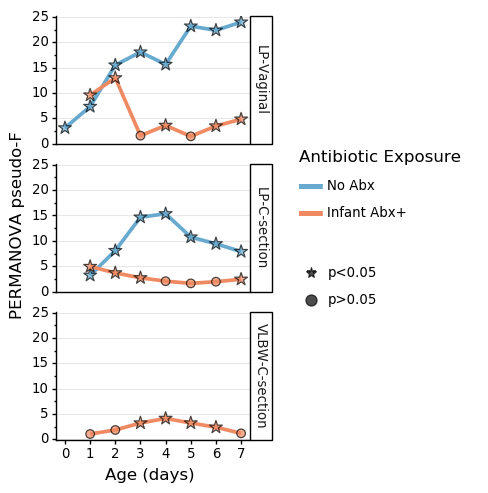

<ggplot: (-9223363281206467275)>

In [13]:
pn.options.figure_size = (2.5,5.5)
plot_dat = perm_df_mbx_abx.copy()
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
plot_dat["cohort"] = pd.Categorical(plot_dat.cohort, ordered=True, categories=cohorts)
plot_dat["value"] = [float(x) for x in plot_dat["test statistic"]]
abx_dict = {0.0: "No Abx",
           1.0: "Infant Abx+"}
plot_dat["abx"] = pd.Categorical([abx_dict[x] for x in plot_dat["abx"]], categories=["No Abx","Infant Abx+"])
plot_dat = plot_dat.query('day in [0,1,2,3,4,5,6,7]')

colors=["#67a9cf","#ef8a62","#b2df8a"]
#colors=['#b2df8a','#1f78b4','#a6cee3']

p = (pn.ggplot(data=plot_dat) +
    pn.geom_line( pn.aes( x="day", y="value", color="abx"), size=1.5) +
    pn.geom_point( pn.aes( x="day", y="value", fill="abx", shape="sig", size="sig"), alpha=.7) +
     pn.scale_size_manual([5,3]) +
     pn.scale_fill_manual(colors) +
     pn.scale_color_manual(colors) +
     pn.scale_shape_manual( values=["*","o"]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.facet_grid('cohort~.') +
     pn.guides( color=pn.guide_legend(override_aes={"size":2}),
               size=None,
              fill =None,
              shape = pn.guide_legend(override_aes={"size":4})) +
     pn.labs(x="Age (days)", y="PERMANOVA pseudo-F", color="Antibiotic Exposure\n", shape="") +
    pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey",alpha=.5),
             axis_ticks_minor_x = pn.element_blank(),
             axis_text = pn.element_text(color="black"),
             panel_spacing = .2)
    )
p.save(root_dir + "results/figures/svg/16S_deicode_permF_over_time_metabolomicsABX.svg", dpi=300)
p.save(root_dir + "results/figures/16S_deicode_permF_over_time_metabolomicsABX.pdf", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/utils.py:49: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)


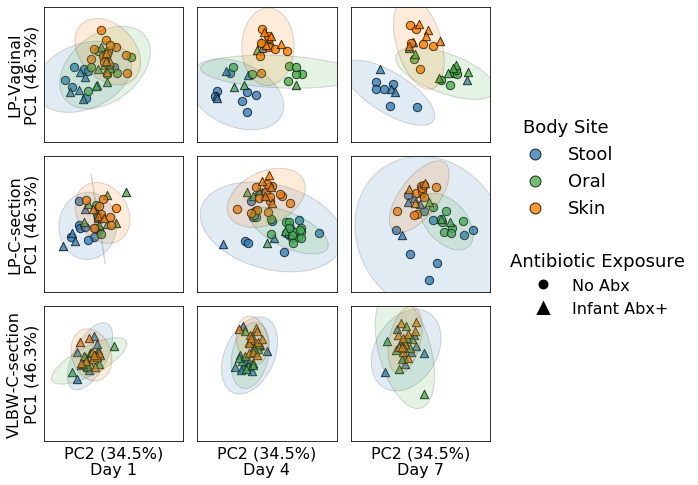

In [66]:
ordination = biplot.view(OrdinationResults)
ordinaiton_samples = ordination.samples
ordinaiton_samples.columns = ["Axis1","Axis2","Axis3"]
ordination_variances = ordination.proportion_explained
ordinaiton_samples = ordinaiton_samples.merge(md, right_index=True, left_index=True)
plot_variances = {"PC1":round(ordination_variances[0]*100,1),"PC2":round(ordination_variances[1]*100,1)}

#Axis boundaries
buffer=.02
xmax = ordinaiton_samples.Axis1.max() + buffer
xmin = ordinaiton_samples.Axis1.min() - buffer
ymax = ordinaiton_samples.Axis2.max() + buffer
ymin = ordinaiton_samples.Axis2.min() - buffer

days = [1,4,7]
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
sample_types = ["Stool","Oral","Skin"]
colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
color_dict = {x:y for x,y in zip(sample_types,colors)}

abx_list = [0,1]
shape_list = ["o","^"]
#["#d55e00","#0072b2""#009e73"]
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(8,8))
fig.subplots_adjust(wspace=0.1, hspace=.1)
for i in range(len(cohorts)):
    for j in range(len(days)):
        for C in sample_types:
            for ab in range(len(abx_list)):
                #data_subset = ordinaiton_samples.loc[ (deicode_ord["study_delivery_mode"] == cohorts[i]) & (deicode_ord["age"] == days[j]) & (deicode_ord["sample_type"] == C) & (deicode_ord.abx_any_source == abx_list[ab])]
                data_subset = ordinaiton_samples.query('study_delivery_mode==@cohorts[@i] & age==@days[@j] & sample_type==@C & abx_any_source==@abx_list[@ab]')
                x= data_subset.Axis1
                y=  data_subset.Axis2
                
                if i==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], alpha=.15,edgecolor= "black" )
                if i==1 and ab==2:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                if ab==0:
                    confidence_ellipse(x,y,axs[i,j],facecolor=color_dict[C], edgecolor= "black",alpha=.15 )
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=C, edgecolors="black", linewidth=1)
                else:
                    axs[i,j].scatter(x, y, s=70, alpha=.8, c = color_dict[C], marker = shape_list[ab], label=None, edgecolors="black", linewidth=1)
                
                #axs[i,j].legend()
        axs[i,j].set_ylim([ymin,ymax])
        axs[i,j].set_xlim([xmin,xmax])
        if i == 2 :
            axs[i,j].set_xlabel("PC2 ({}%)\n".format(plot_variances["PC2"]) + "Day " + str(days[j]) , size=16)
        if j==0:
            axs[i,j].set_ylabel(cohorts[i] + "\nPC1 ({}%)".format(plot_variances["PC1"]), size=16)
        #remove axis text and ticks
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
#Abx legend
point = Line2D([0], [0], marker='.', color='w', label='Scatter', markerfacecolor='black', markersize=22)
star = Line2D([0], [0], marker='^', color='w', label='Scatter', markerfacecolor='black', markersize=16)
dia = Line2D([0], [0], marker='D', color='w', label='Scatter', markerfacecolor='black', markersize=12)
leg1 = plt.legend([point,star,dia],['No Abx','Infant Abx+'], 
                  bbox_to_anchor=(2.50, 1.5), loc='upper right', ncol=1,fontsize=14,frameon=False,prop={'size': 16},
                  title="Antibiotic Exposure", title_fontsize=18)
lgd =plt.legend(loc='upper right',bbox_to_anchor=[2.0, 2.5], ncol=1, 
                fontsize=14,frameon=False,prop={'size': 18}, title="Body Site", title_fontsize=18)
for handle in lgd.legendHandles:
    handle.set_sizes([120]) 
plt.gca().add_artist(leg1) 

#plt.tight_layout()
fig.savefig(root_dir + 'results/figures/deicode_pcoa_grid_metabolomicsABX.pdf', bbox_extra_artists=(lgd,), 
            bbox_inches='tight',pad_inches = 1, dpi=300)
plt.show()

___

# Calculate distance over time

In [19]:
deicode_dm_df = dm.view(DistanceMatrix).to_data_frame()
#deicode_dm_df = jaccard_df
dm_samples = set(deicode_dm_df.index)
md_ss = md.query('index in @dm_samples')

In [20]:

out_list_j = []
host_list = set( md_ss.host_subject_id )
for host in host_list:
    for sample_type in ["Stool","Oral","Skin"]:
        host_md_ss = md_ss.query('host_subject_id==@host & sample_type==@sample_type')
        if not len(host_md_ss):
            continue
        if host_md_ss.qiita_study_id[0] == 11712:
            earliest_tp=0
            study="doty"
        else:
            study="stillwell"
            earliest_tp=1
        earliest_sample = host_md_ss.query('age==@earliest_tp').index.values
        if not len(earliest_sample):
            continue
        d_mode = host_md_ss.delivery_mode[0]
        earliest_sample = earliest_sample[0]
        for s,row in host_md_ss.iterrows():
            t = row.age
            abx=row.metadata_abx
            if t<=earliest_tp:
                continue
            temp_dist = deicode_dm_df.loc[earliest_sample,s]
            out_list_j.append([study,d_mode,host,sample_type,abx, t,temp_dist])
jdf = pd.DataFrame(out_list_j, columns=["study","delivery_mode","host_subject_id","sample_type","metadata_abx","age","d"])


In [21]:

lm_list = []
for study in ["doty","stillwell"]:
    for delivery_mode in ["c-section","vaginal"]:
        if study=="stillwell" and delivery_mode=="vaginal":
            continue
        for sample_type in ["Stool","Oral","Skin"]:
            temp = jdf.query('sample_type==@sample_type & study==@study & delivery_mode ==@delivery_mode')
            if study=="stillwell":
                temp = temp.query('age not in [1,0]')
            else:
                temp = temp.query('age not in [0]')
            X = temp.age
            y = temp.d

            X2 = sm.add_constant(X)
            est = sm.OLS(y, X2)

            intercept = float(est.fit().summary().tables[1].data[1][1])
            slope = float(est.fit().summary().tables[1].data[2][1])
            pvalue=est.fit().f_pvalue
            Rsq = est.fit().summary().tables[0].data[0][3]

            lm_list.append([study,delivery_mode,sample_type,intercept,slope,Rsq, pvalue])
lm_df = pd.DataFrame(lm_list, columns=["study","delivery_mode","sample_type","intercept","slope","R2", "p"])
lm_df["sig"] = lm_df.p < .05

lm_df["all_info"] = lm_df.apply(axis=1, func=lambda row: "R2={}\nslope={}".format(row.R2.strip(),
                                                                                       row.slope))
lm_plot_dat= lm_df.copy()
lm_plot_dat["sample_type"] = pd.Categorical(lm_plot_dat.sample_type, categories=["Stool","Oral","Skin"], ordered=True)
lm_plot_dat['p'] = [round(x,4) for x in lm_plot_dat.p]
lm_plot_dat['p_text'] = ["p={}".format(x) for x in lm_plot_dat.p]
lm_plot_dat = lm_plot_dat.replace({"p=0.0":"p<0.0001"})
lm_plot_dat["weight"] = ["LP" if x=="doty" else "VLBW" for x in lm_plot_dat.study]
sdm_dict = {"doty_c-section": "LP-C-section",
           "doty_vaginal":"LP-Vaginal",
           "stillwell_c-section":"VLBW-C-section"}
lm_plot_dat["study_delivery_mode"] = lm_plot_dat.apply(axis=1, func=lambda row: sdm_dict[row.study + "_" + row.delivery_mode])
lm_plot_dat["study_delivery_mode"] = pd.Categorical(lm_plot_dat["study_delivery_mode"], categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/16S_deicode_nbx_distance_to_baseline.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/16S_deicode_nbx_distance_to_baseline.pdf
  warn('Filename: {}'.f

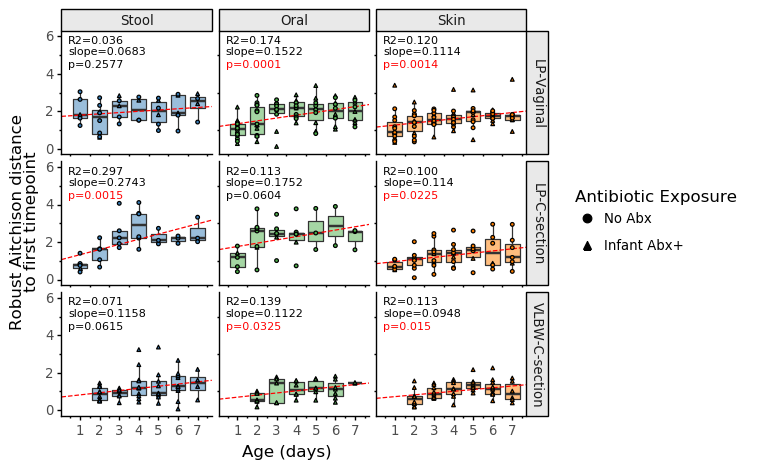

<ggplot: (-9223363292001082231)>

In [23]:
pn.options.figure_size = (6,5)
plot_dat=jdf.copy()
plot_dat["study"] = [x.split("-")[0] for x in plot_dat.host_subject_id]
colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type, categories=["Stool","Oral","Skin"], ordered=True)
plot_dat["weight"] = ["LP" if x=="doty" else "VLBW" for x in plot_dat.study]
sdm_dict = {"11712_c-section": "LP-C-section",
           "11712_vaginal":"LP-Vaginal",
           "11713_c-section":"VLBW-C-section"}
plot_dat["study_delivery_mode"] = plot_dat.apply(axis=1, func=lambda row: sdm_dict[row.study + "_" + row.delivery_mode])
plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat["study_delivery_mode"], categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])
abx_dict = {0: "No Abx",
           1: "Infant Abx+"}


plot_dat["abx_label"] = pd.Categorical([abx_dict[x] for x in plot_dat["metadata_abx"]], categories=["No Abx","Infant Abx+"])

#plot_dat["abx_category"]


p = (pn.ggplot(data = plot_dat) +
     pn.geom_boxplot( pn.aes(x="age",y="d", group="age", fill="sample_type"), outlier_alpha=0, alpha=.5) +
     pn.geom_abline(data = lm_plot_dat,  mapping=pn.aes(intercept="intercept", slope="slope"), color="red",linetype="dashed") +
     pn.geom_text(data = lm_plot_dat, mapping = pn.aes(x=.4,y=5.5, label="all_info"),size=8, hjust="left") +
     pn.geom_text(data = lm_plot_dat, mapping = pn.aes(x=.4,y=4.5, label="p_text", color="sig"),size=8, hjust="left") +
     pn.geom_point( pn.aes(x="age",y="d", group="age", shape="abx_label", fill="sample_type"), size=1, alpha=1, color="black") +
     pn.facet_grid('study_delivery_mode~sample_type', scales="free", space="free")+
     pn.scale_fill_manual(values=colors) +
     pn.scale_color_manual(values=["black","red"]) +
     pn.scale_shape_manual(values=["o","^","D"]) +
     pn.guides(color=None, fill=None) +
     pn.scale_y_continuous(limits=[0,6]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.labs(x="Age (days)", y="Robust Aitchison distance\nto first timepoint", shape="Antibiotic Exposure") +
     pn.guides(shape = pn.guide_legend(override_aes={"size":3})) +
     pn.theme_classic(base_size=12) +
     pn.theme(strip_background=pn.element_rect(fill="#E9E9E9"))
     
    )
p.save(root_dir + "results/figures/svg/16S_deicode_nbx_distance_to_baseline.svg", dpi=300)
p.save(root_dir + "results/figures/16S_deicode_nbx_distance_to_baseline.pdf", dpi=300)
p

_____

# Songbird

!mkdir $root_dir/intermediate_data/16S_songbird/old
!mv $root_dir/intermediate_data/16S_songbird/*.qza $root_dir/intermediate_data/16S_songbird/old
!mv $root_dir/intermediate_data/16S_songbird/*.qzv $root_dir/intermediate_data/16S_songbird/old

100%|██████████| 29000/29000 [00:14<00:00, 1954.59it/s]


1039 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Stool 0 q2:0.072475


100%|██████████| 25000/25000 [00:12<00:00, 2032.39it/s]


1070 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Stool 1 q2:0.020484


100%|██████████| 29000/29000 [00:14<00:00, 2022.40it/s]


1076 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Oral 0 q2:0.014276


100%|██████████| 26000/26000 [00:12<00:00, 2008.57it/s]


1057 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Oral 1 q2:0.011843


100%|██████████| 29000/29000 [00:14<00:00, 1957.52it/s]


1054 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Skin 0 q2:-0.023785


100%|██████████| 28000/28000 [00:14<00:00, 1982.15it/s]


1068 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Skin 1 q2:-0.499994


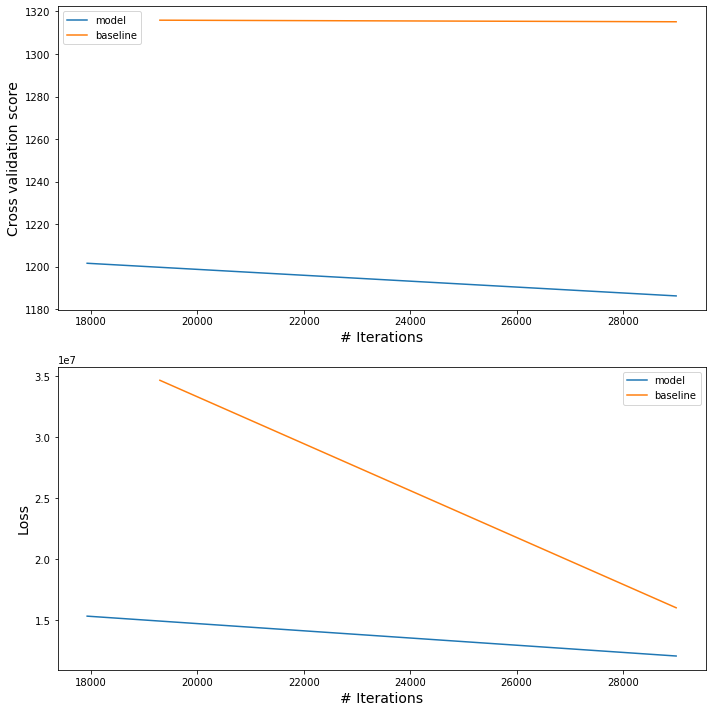

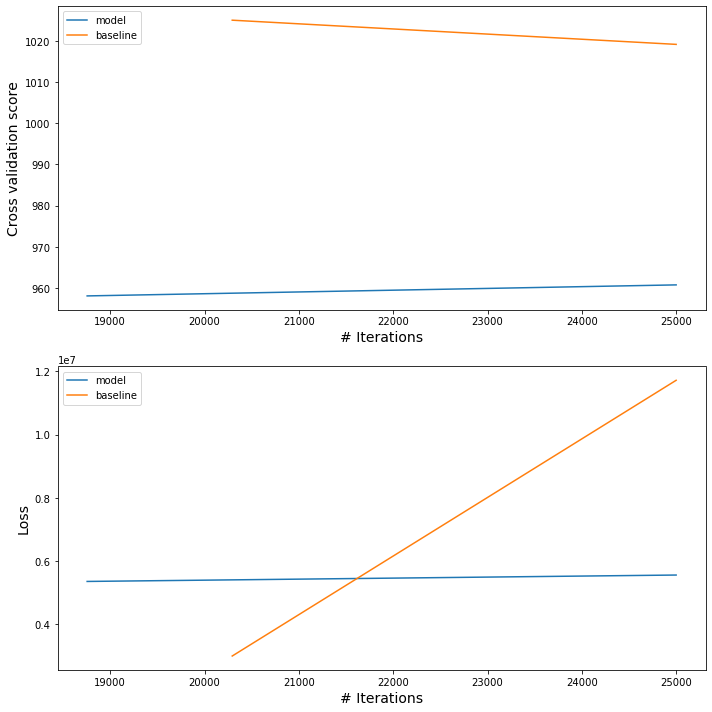

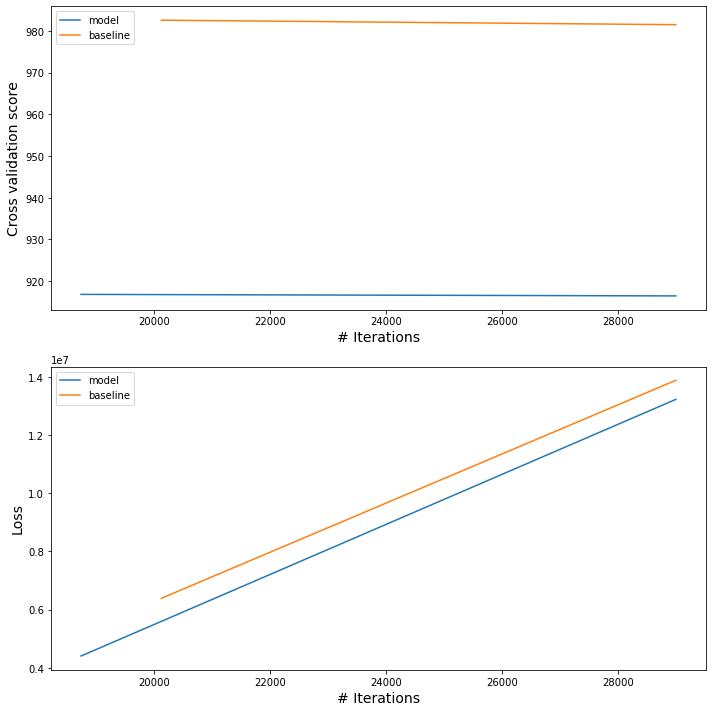

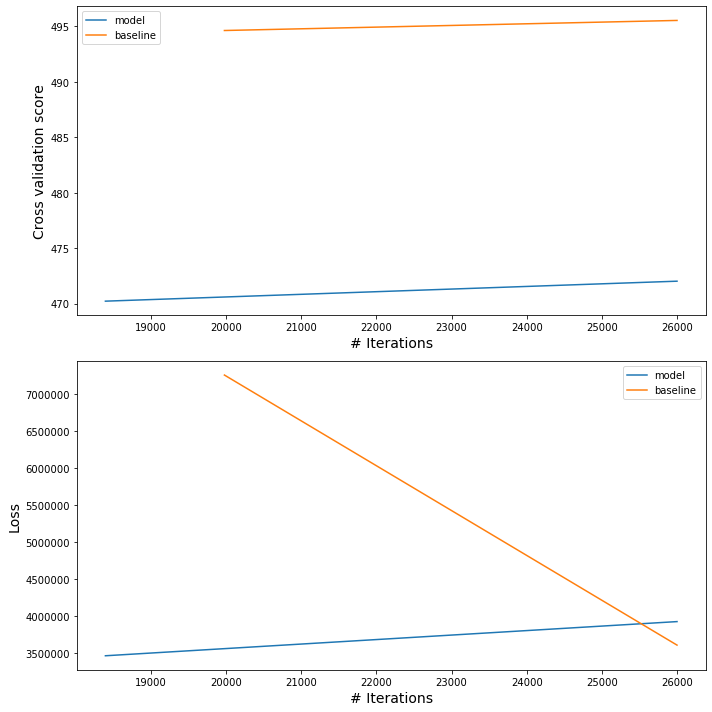

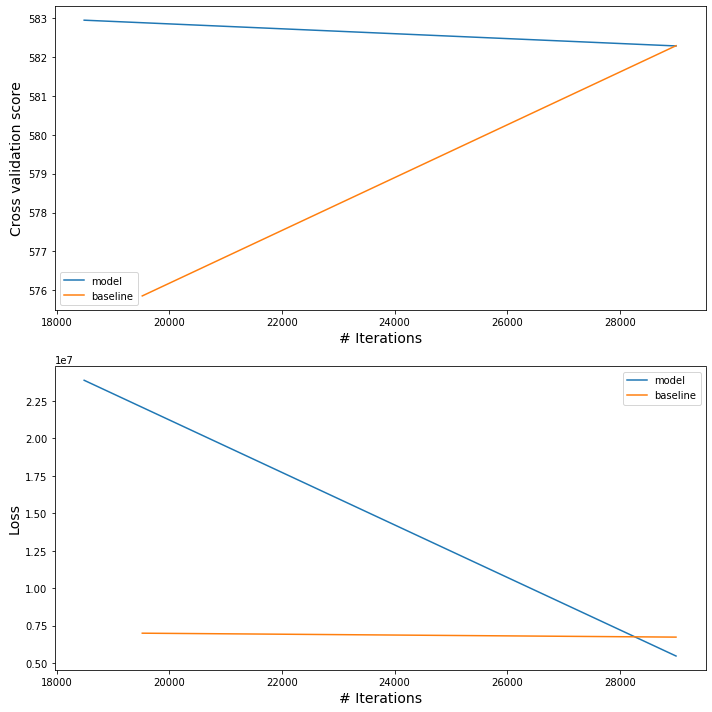

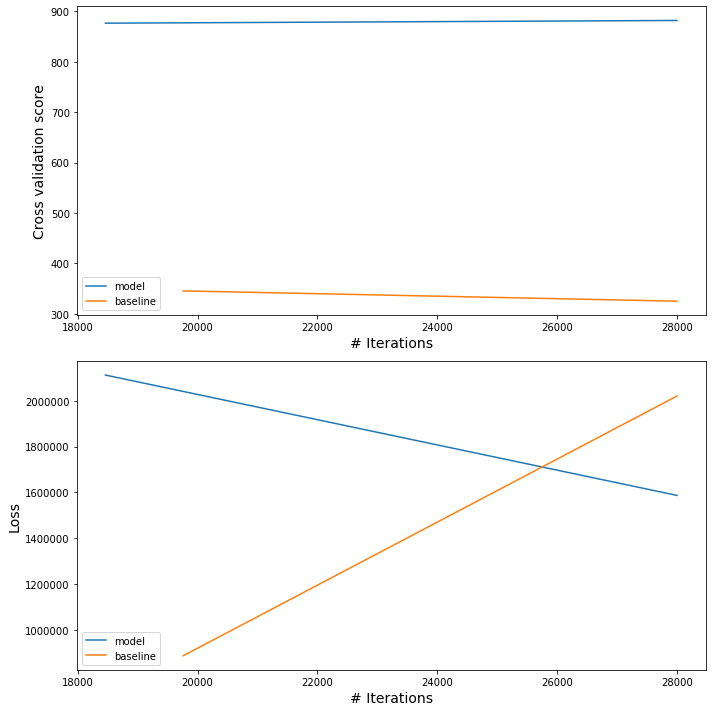

In [219]:
#Run/Import Songbird
out_folder= root_dir + "/intermediate_data/16S_songbird/"
!mkdir -p $out_folder

md["milk"] = md.randomization.replace({"mother's own milk":"mom_milk",
                                      "Donor human milk":"donor_milk",
                                      "Formula":"formula"})


songbird_dict = {}
formula= "C(study_delivery_mode, Treatment('LPI-Vaginal')) + age + C(milk, Treatment('formula'))"



for sample_type in ["Stool","Oral","Skin"]:
    songbird_dict[sample_type] = {}
    for abx in [0,1]:
        songbird_dict[sample_type][abx] = {}
        md_ss = md.query('sample_type==@sample_type & metadata_abx==@abx')
        samples_keep = set(md_ss.index)
        temp_bt = genus_bt.filter(samples_keep, inplace=False)

        temp_qza = q2.Artifact.import_data('FeatureTable[Frequency]', temp_bt)
        temp_md_qza = q2.Metadata(md_ss)
        #temp_feature_md_qza = q2.Metadata(temp_feature_md)
        #Run songbird
        (temp_differentials,
         temp_regression_stats,
         temp_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula=formula)

        #Run null model (just sex)
        (null_differentials,
         null_regression_stats,
         null_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula="1")
        #Run qurro
        tmp_qurro = differential_plot(ranks= temp_differentials,
                                        table= temp_qza,
                                        sample_metadata=temp_md_qza,
                                       feature_metadata=tax_md_qza).visualization
        #Evaluate model fit
        tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                        baseline_stats = null_regression_stats).visualization
        #Add outputs to master dictionary
        songbird_dict[sample_type][abx]["differentials"] = temp_differentials
        songbird_dict[sample_type][abx]["regression_stats"] = temp_regression_stats
        songbird_dict[sample_type][abx]["regression_biplot"] = temp_regression_biplot
        songbird_dict[sample_type][abx]["qurro"] = tmp_qurro
        songbird_dict[sample_type][abx]["model_fit"] = tmp_model_fit
        #Save outputs
        temp_differentials.save(out_folder + "{}_{}_differentials.qza".format(sample_type,abx))
        temp_regression_stats.save(out_folder + "{}_{}_regression_stats.qza".format(sample_type,abx))
        temp_regression_biplot.save(out_folder + "{}_{}_regression_biplot.qza".format(sample_type,abx))
        tmp_qurro.save(out_folder + "{}_{}_qurro.qzv".format(sample_type,abx))
        tmp_model_fit.save(out_folder + "{}_{}_model_fit.qzv".format(sample_type,abx))

        #Get q2
        q_square = get_q2(out_folder + "{}_{}_model_fit.qzv".format(sample_type,abx))
        songbird_dict[sample_type][abx]["q_square"] = q_square
        print("{} {} q2:{}".format(sample_type, abx, q_square))
                                                    

In [24]:
out_folder= root_dir + "/intermediate_data/16S_songbird/"
songbird_dict = {}
for sample_type in ["Stool","Oral","Skin"]:
    songbird_dict[sample_type] = {}
    for abx in [1,0]:
        songbird_dict[sample_type][abx] = {}
        songbird_dict[sample_type][abx]["differentials"] = q2.Artifact.load(out_folder + "{}_{}_differentials.qza".format(sample_type,abx))
        songbird_dict[sample_type][abx]["regression_stats"] = q2.Artifact.load(out_folder + "{}_{}_regression_stats.qza".format(sample_type,abx))
        songbird_dict[sample_type][abx]["regression_biplot"] = q2.Artifact.load(out_folder + "{}_{}_regression_biplot.qza".format(sample_type,abx))
        songbird_dict[sample_type][abx]["qurro"] = q2.Visualization.load(out_folder + "{}_{}_qurro.qzv".format(sample_type,abx))

In [225]:
print("formula:  age + delivery_mode + metadata_abx")
for k,v in songbird_dict.items():
    for k2,v2 in v.items():
        print(k,k2,v2["q_square"])

formula:  age + delivery_mode + metadata_abx
Stool 0 0.072475
Stool 1 0.020484
Oral 0 0.014276
Oral 1 0.011843
Skin 0 -0.023785
Skin 1 -0.499994


In [25]:
th_props = [
  ('font-size', '13px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'black'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
    ('text-align', 'center')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

compare_lpi="C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]"
compare_vlbw="C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]"

compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}

In [57]:

th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'black'),
  ('background-color', '#f7f7f9'),
    ('font-family','Helvetica')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
    ('text-align', 'center')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

n=5
inc_1= get_increasing_list(songbird_dict,0, "Stool","age",n)
inc_2= get_increasing_list(songbird_dict,0, "Oral","age",n)
inc_3= get_increasing_list(songbird_dict,0, "Skin","age",n)

dec_1= get_decreasing_list(songbird_dict,0, "Stool","age",n)
dec_2= get_decreasing_list(songbird_dict,0, "Oral","age",n)
dec_3= get_decreasing_list(songbird_dict,0, "Skin","age",n)

head = """
<table>
    <thead>
        <th> </th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Stool</th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Oral</th>
    </thead>
    </tbody>

"""
rows = {"Increased X with age".replace(" X ","<br />\n"):[inc_1, inc_2],
       "Decreased X with age".replace(" X ","<br />\n"):[dec_1,dec_2]}

for k,v in rows.items():
    row = '<tr><th style="text-align: center; font-size:14px; vertical-align: center; font-family:Helvetica">{}</th>'.format(k)
    for serie in v:
        s = serie.copy()
        s.index=range(1,n+1)
        s.name=''
        if s.iloc[1,1] > 0:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmin=0,vmax=7,
                                                            color=['#67a9cf'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
        else:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmax=0,vmin=-7,
                                                            color=['#ef8a62'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
    row += '</tr>'
    head += row

head+= """
</tbody>
</table>"""





out_folder= root_dir + "/results/tables/"
with open(out_folder + "16S_songbird_age_table.html", 'w') as f:
    f.write(head)
HTML(head)

In [56]:

th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'black'),
  ('background-color', '#f7f7f9'),
    ('font-family','Helvetica')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
    ('text-align', 'center'),
    ('white-space','pre-wrap')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

n=5
inc_1= get_increasing_list(songbird_dict,0, "Stool","C(milk, Treatment('formula'))[T.donor_milk]",n)
inc_2= get_increasing_list(songbird_dict,0, "Oral","C(milk, Treatment('formula'))[T.donor_milk]",n)
inc_3= get_increasing_list(songbird_dict,0, "Skin","age",n)

dec_1= get_decreasing_list(songbird_dict,0, "Stool","C(milk, Treatment('formula'))[T.donor_milk]",n)
dec_2= get_decreasing_list(songbird_dict,0, "Oral","C(milk, Treatment('formula'))[T.donor_milk]",n)
dec_3= get_decreasing_list(songbird_dict,0, "Skin","age",n)

head = """
<table>
    <thead>
        <th> </th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Stool</th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Oral</th>
    </thead>
    </tbody>

"""
rows = {"Increased in X breastmilk-supplemented".replace(" X ","<br />\n"):[inc_1, inc_2],
       "Increased in X formula-supplemented".replace(" X ","<br />\n"):[dec_1,dec_2]}

for k,v in rows.items():
    row = '<tr><th style="text-align: center; font-size:14px; vertical-align: center; font-family:Helvetica">{}</th>'.format(k)
    for serie in v:
        s = serie.copy()
        s.index=range(1,n+1)
        s.name=''
        if s.iloc[1,1] > 0:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmin=0,vmax=10,
                                                            color=['#67a9cf'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
        else:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmax=0,vmin=-10,
                                                           color=['#ef8a62'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
    row += '</tr>'
    head += row

head+= """
</tbody>
</table>"""





out_folder= root_dir + "/results/tables/"
with open(out_folder + "16S_songbird_BM_table.html", 'w') as f:
    f.write(head)
HTML(head)

In [64]:
songbird_dict["Stool"][0]["differentials"].view(pd.DataFrame)

,Intercept,"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]","C(milk, Treatment('formula'))[T.donor_milk]",age
featureid,,,,
k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Nitrososphaerales;f__Nitrososphaeraceae;g__Candidatus Nitrososphaera,1.650490,-0.354182,0.052350,0.522147
k__Bacteria;__;__;__;__;__,-0.236008,-1.383344,-0.225574,-0.371287
k__Bacteria;p__Acidobacteria;c__Acidobacteria-5;o__;f__;g__,0.011624,1.177546,0.423732,-0.350792
k__Bacteria;p__Acidobacteria;c__Acidobacteria-6;o__iii1-15;f__;g__,2.370847,0.763243,0.513530,-0.233074
k__Bacteria;p__Acidobacteria;c__Acidobacteria-6;o__iii1-15;f__RB40;g__,0.888771,0.810787,0.109717,-0.220079
...,...,...,...,...
k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__DA101,2.831857,0.700582,0.729659,-0.212417
k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__OR-59,0.037034,0.415614,-0.320610,-0.265170
k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus,-2.248581,0.718588,0.703629,-0.232303


In [68]:

th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'black'),
  ('background-color', '#f7f7f9'),
    ('font-family','Helvetica')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
    ('text-align', 'center'),
    ('white-space','pre-wrap')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

n=5
inc_1= get_increasing_list(songbird_dict,0, "Stool","C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]",n)
inc_2= get_increasing_list(songbird_dict,0, "Oral","C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]",n)
#inc_3= get_increasing_list(songbird_dict,0, "Skin","age",n)

dec_1= get_decreasing_list(songbird_dict,0, "Stool","C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]",n)
dec_2= get_decreasing_list(songbird_dict,0, "Oral","C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]",n)
#dec_3= get_decreasing_list(songbird_dict,0, "Skin","age",n)

head = """
<table>
    <thead>
        <th> </th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Stool</th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Oral</th>
    </thead>
    </tbody>

"""
rows = {"Increased in X C-section-born".replace(" X ","<br />\n"):[inc_1, inc_2],
       "Increased in X Vaginal-born".replace(" X ","<br />\n"):[dec_1,dec_2]}

for k,v in rows.items():
    row = '<tr><th style="text-align: center; font-size:14px; vertical-align: center; font-family:Helvetica">{}</th>'.format(k)
    for serie in v:
        s = serie.copy()
        s.index=range(1,n+1)
        s.name=''
        if s.iloc[1,1] > 0:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmin=0,vmax=10,
                                                            color=['#67a9cf'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
        else:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmax=0,vmin=-10,
                                                           color=['#ef8a62'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
    row += '</tr>'
    head += row

head+= """
</tbody>
</table>"""





out_folder= root_dir + "/results/tables/"
with open(out_folder + "16S_songbird_DM_table.html", 'w') as f:
    f.write(head)
HTML(head)

## Songbird dor effect of antibiotics
Not split by antibiotics

In [72]:
md_ss = md.query('sample_type==@sample_type')
samples_keep = set(md_ss.index)

In [75]:
md_ss.metadata_abx.value_counts()

0.0    177
1.0    153
Name: metadata_abx, dtype: int64

100%|██████████| 56000/56000 [00:29<00:00, 1908.25it/s]


977 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Stool q2:0.222490


100%|██████████| 56000/56000 [00:35<00:00, 1579.13it/s]


1001 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Oral q2:0.316040


100%|██████████| 59000/59000 [00:26<00:00, 2211.09it/s]


1009 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Skin q2:0.037530


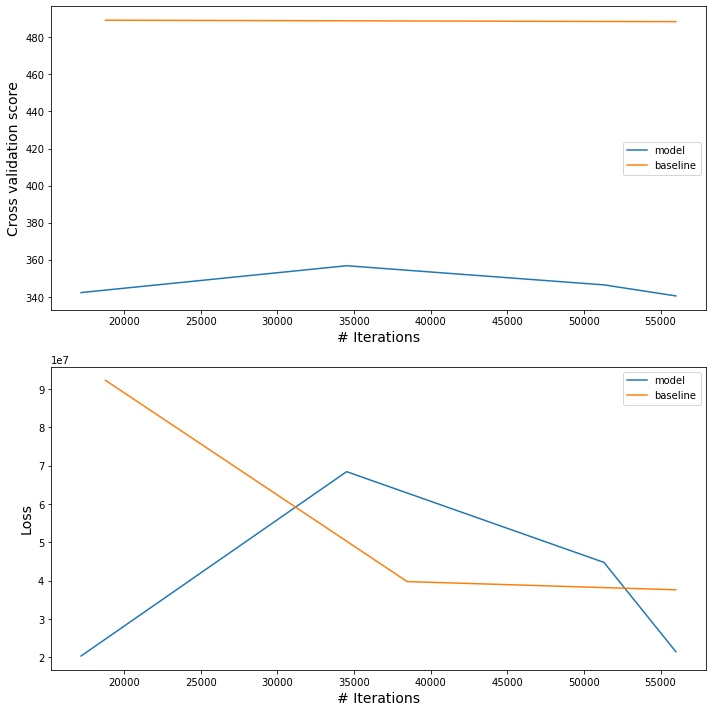

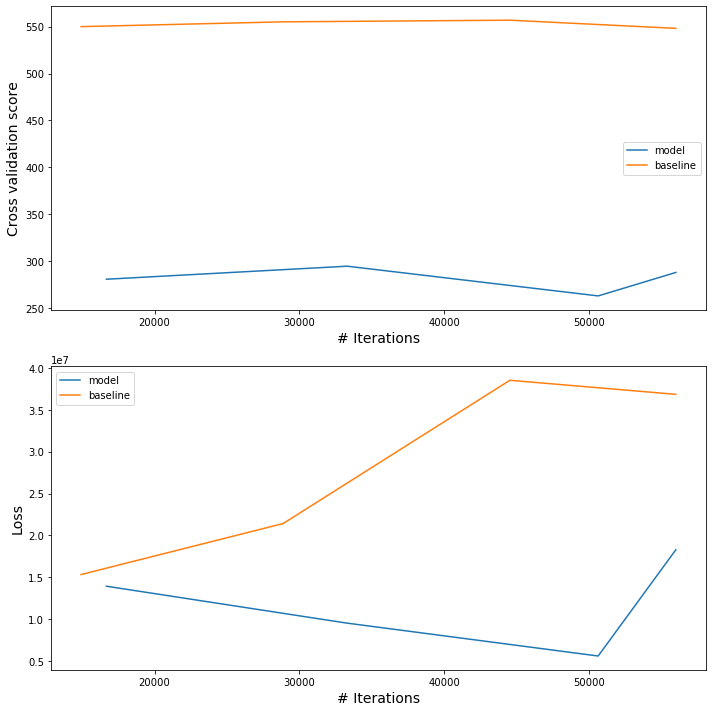

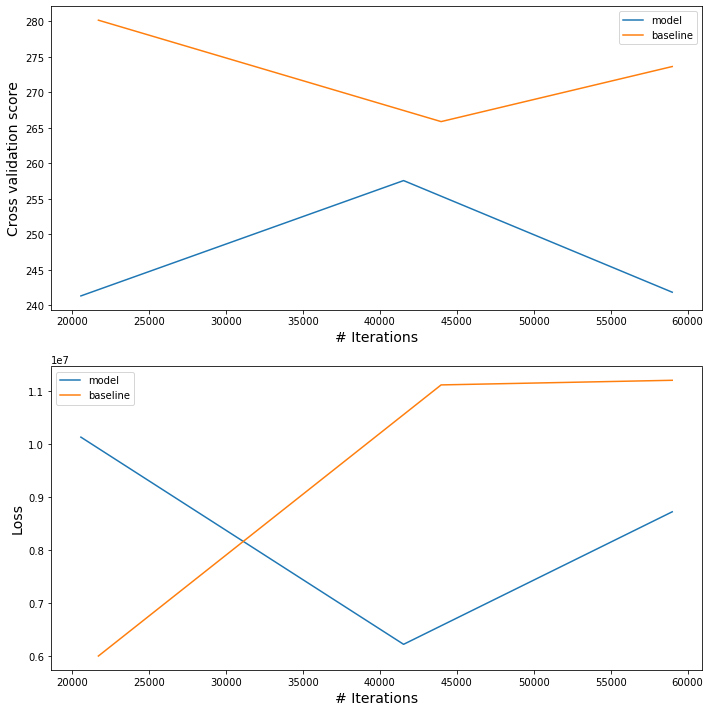

In [220]:
#Run/Import Songbird
out_folder= root_dir + "/intermediate_data/16S_abx_songbird/"
!mkdir -p $out_folder

md["milk"] = md.randomization.replace({"mother's own milk":"mom_milk",
                                      "Donor human milk":"donor_milk",
                                      "Formula":"formula"})

songbird_abx_dict = {}
formula= "C(study_delivery_mode, Treatment('LPI-Vaginal')) + age  + metadata_abx"

for sample_type in ["Stool","Oral","Skin"]:
    md_ss = md.query('sample_type==@sample_type')
    samples_keep = set(md_ss.index)
    temp_bt = genus_bt.filter(samples_keep, inplace=False)
    
    temp_qza = q2.Artifact.import_data('FeatureTable[Frequency]', temp_bt)
    temp_md_qza = q2.Metadata(md_ss)
    #temp_feature_md_qza = q2.Metadata(temp_feature_md)
    #Run songbird
    (temp_differentials,
     temp_regression_stats,
     temp_regression_biplot) = multinomial(table=temp_qza,
                                           metadata=temp_md_qza,
                                           formula=formula)

    #Run null model (just sex)
    (null_differentials,
     null_regression_stats,
     null_regression_biplot) = multinomial(table=temp_qza,
                                           metadata=temp_md_qza,
                                           formula="1")
    #Run qurro
    tmp_qurro = differential_plot(ranks= temp_differentials,
                                    table= temp_qza,
                                    sample_metadata=temp_md_qza,
                                   feature_metadata=tax_md_qza).visualization
    #Evaluate model fit
    tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                    baseline_stats = null_regression_stats).visualization
    #Add outputs to master dictionary
    songbird_abx_dict[sample_type] = {}
    songbird_abx_dict[sample_type]["differentials"] = temp_differentials
    songbird_abx_dict[sample_type]["regression_stats"] = temp_regression_stats
    songbird_abx_dict[sample_type]["regression_biplot"] = temp_regression_biplot
    songbird_abx_dict[sample_type]["qurro"] = tmp_qurro
    songbird_abx_dict[sample_type]["model_fit"] = tmp_model_fit
    #Save outputs
    temp_differentials.save(out_folder + "{}_differentials.qza".format(sample_type))
    temp_regression_stats.save(out_folder + "{}_regression_stats.qza".format(sample_type))
    temp_regression_biplot.save(out_folder + "{}_regression_biplot.qza".format(sample_type))
    tmp_qurro.save(out_folder + "{}_qurro.qzv".format(sample_type))
    tmp_model_fit.save(out_folder + "{}_model_fit.qzv".format(sample_type))

    #Get q2
    q_square = get_q2(out_folder + "{}_model_fit.qzv".format(sample_type))
    songbird_abx_dict[sample_type]["q_square"] = q_square
    print("{} q2:{}".format(sample_type, q_square))
                                                    

In [221]:
print("formula:  age + delivery_mode + metadata_abx")
for k,v in songbird_abx_dict.items():
        print(k,v["q_square"])

formula:  age + delivery_mode + metadata_abx
Stool 0.222490
Oral 0.316040
Skin 0.037530


In [29]:
out_folder= root_dir + "/intermediate_data/16S_abx_songbird/"
songbird_abx_dict = {}
for sample_type in ["Stool","Oral","Skin"]:
    songbird_abx_dict[sample_type] = {}
    songbird_abx_dict[sample_type] = {}
    songbird_abx_dict[sample_type]["differentials"] = q2.Artifact.load(out_folder + "{}_differentials.qza".format(sample_type))
    songbird_abx_dict[sample_type]["regression_stats"] = q2.Artifact.load(out_folder + "{}_regression_stats.qza".format(sample_type))
    songbird_abx_dict[sample_type]["regression_biplot"] = q2.Artifact.load(out_folder + "{}_regression_biplot.qza".format(sample_type))
    songbird_abx_dict[sample_type]["qurro"] = q2.Visualization.load(out_folder + "{}_qurro.qzv".format(sample_type))
    

In [30]:

def get_top_list2(sbd, sample_type, factor, i):
    temp_df = sbd[sample_type]["differentials"].view(pd.DataFrame)
    temp_df = temp_df.sort_values(factor, ascending=False)
    temp_df_ss = temp_df.iloc[top_bottom(i)].copy()
    temp_df_ss["Genus"] = [shorten_taxon(x) for x in temp_df_ss.index]
    #temp_df_ss = temp_df_ss.loc[["mitochondria" not in x for x in temp_df_ss.Taxon]]
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Genus",factor ]]
    temp_df_ss.columns=["Genus","Differential"]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)

def get_increasing_list2(sbd, sample_type, factor, i):
    temp_df = sbd[sample_type]["differentials"].view(pd.DataFrame)
    temp_df = temp_df.sort_values(factor, ascending=False)
    temp_df_ss = temp_df.iloc[range(i)].copy()
    temp_df_ss["Genus"] = [shorten_taxon(x) for x in temp_df_ss.index]
    #temp_df_ss = temp_df_ss.loc[["mitochondria" not in x for x in temp_df_ss.Taxon]]
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Genus",factor ]]
    temp_df_ss.columns=["Genus","Songbird Differential"]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)

def get_decreasing_list2(sbd, sample_type, factor, i):
    temp_df = sbd[sample_type]["differentials"].view(pd.DataFrame)
    temp_df = temp_df.sort_values(factor, ascending=False)
    temp_df_ss = temp_df.iloc[[-x for x in range(1,i+1)]].copy()
    temp_df_ss["Genus"] = [shorten_taxon(x) for x in temp_df_ss.index]
    #temp_df_ss = temp_df_ss.loc[["mitochondria" not in x for x in temp_df_ss.Taxon]]
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Genus",factor ]]
    temp_df_ss.columns=["Genus","Songbird Differential"]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)



In [69]:

th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'black'),
  ('background-color', '#f7f7f9'),
    ('font-family','Helvetica')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
    ('text-align', 'center')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

n=5

inc_1= get_increasing_list2(songbird_abx_dict, "Stool","metadata_abx",n)
inc_2= get_increasing_list2(songbird_abx_dict, "Oral","metadata_abx",n)
inc_3= get_increasing_list2(songbird_abx_dict, "Skin","metadata_abx",n)

dec_1= get_decreasing_list2(songbird_abx_dict, "Stool","metadata_abx",n)
dec_2= get_decreasing_list2(songbird_abx_dict, "Oral","metadata_abx",n)
dec_3= get_decreasing_list2(songbird_abx_dict, "Skin","metadata_abx",n)

head = """
<table>
    <thead>
        <th> </th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Stool</th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Oral</th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Skin</th>
    </thead>
    </tbody>

"""
rows = {"Increased X with X antibiotics".replace(" X ","<br />\n"):[inc_1, inc_2, inc_3],
       "Decreased X with X antibiotics".replace(" X ","<br />\n"):[dec_1,dec_2,dec_3]}

for k,v in rows.items():
    row = '<tr><th style="text-align: center; font-size:14px; vertical-align: center; font-family:Helvetica">{}</th>'.format(k)
    for serie in v:
        s = serie.copy()
        s.index=range(1,n+1)
        s.name=''
        if s.iloc[1,1] > 0:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmin=0,vmax=7,
                                                           color=['#67a9cf'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
        else:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmax=0,vmin=-7,
                                                           color=['#ef8a62'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
    row += '</tr>'
    head += row

head+= """
</tbody>
</table>"""





out_folder= root_dir + "/results/tables/"
with open(out_folder + "16S_songbird_abx_table.html", 'w') as f:
    f.write(head)
HTML(head)

In [296]:
print("formula:  age + delivery_mode + metadata_abx + randomization")
for k,v in songbird_rand_dict.items():
    print(k,v["q_square"])

formula:  age + delivery_mode + metadata_abx + randomization
Stool 0.069908
Oral 0.288075
Skin -0.100114


In [302]:
md.groupby("study_delivery_mode").randomization.value_counts()

study_delivery_mode  randomization    
LPI-C-section        Formula              217
                     Donor human milk     164
LPI-Vaginal          Donor human milk     169
                     Formula              165
VLBW-C-section       mother's own milk    198
                     Donor human milk      76
Name: randomization, dtype: int64

In [26]:
get_top_list(songbird_dict,0,"Stool","C(milk, Treatment('formula'))[T.donor_milk]",5).style.bar(align="mid")

,Genus,Differential
0,f__Staphylococcaceae;g__Staphylococcus,2.41976
1,f__Thermaceae;g__Thermus,1.72748
2,f__Bacillaceae;g__Geobacillus,1.41072
3,f__Bacillaceae;g__Bacillus,1.36005
4,f__Pseudomonadaceae;__,1.25556
5,f__Clostridiaceae;g__Clostridium,-2.77801
6,f__Peptostreptococcaceae;g__[Clostridium],-3.77356
7,f__Pasteurellaceae;__,-6.71975
8,f__Enterobacteriaceae;g__Serratia,-9.45729
9,f__Pasteurellaceae;g__Aggregatibacter,-9.81266


In [25]:
get_top_list(songbird_dict,0,"Oral","C(milk, Treatment('formula'))[T.donor_milk]",5).style.bar(align="mid")

,Genus,Differential
0,f__Carnobacteriaceae;g__Granulicatella,3.33898
1,f__Mycoplasmataceae;g__Ureaplasma,3.17869
2,f__Moraxellaceae;g__Acinetobacter,2.89845
3,f__Pseudomonadaceae;g__Pseudomonas,2.57262
4,f__Xanthomonadaceae;g__Stenotrophomonas,2.45093
5,f__Lachnospiraceae;g__Clostridium,-3.23048
6,f__Ruminococcaceae;g__Ruminococcus,-3.28689
7,f__Lachnospiraceae;g__,-3.86262
8,f__Lachnospiraceae;g__Roseburia,-4.40154
9,f__Carnobacteriaceae;__,-5.2698


# Songbird effect of milk
Only LPI infants



Instructions for updating:
Use `tf.random.categorical` instead.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






  0%|          | 0/29000 [00:00<?, ?it/s]

100%|██████████| 29000/29000 [00:22<00:00, 1277.55it/s]


1039 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Stool 0 q2:0.081097


100%|██████████| 9000/9000 [00:06<00:00, 1294.35it/s]


1111 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Stool 1 q2:0.112541


100%|██████████| 29000/29000 [00:22<00:00, 1293.57it/s]


1076 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Oral 0 q2:0.019748


100%|██████████| 10000/10000 [00:07<00:00, 1280.41it/s]


1103 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Oral 1 q2:-0.055010


100%|██████████| 29000/29000 [00:22<00:00, 1287.01it/s]


1054 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Skin 0 q2:-0.032258


100%|██████████| 8000/8000 [00:06<00:00, 1294.97it/s]


1117 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
Skin 1 q2:-0.119452


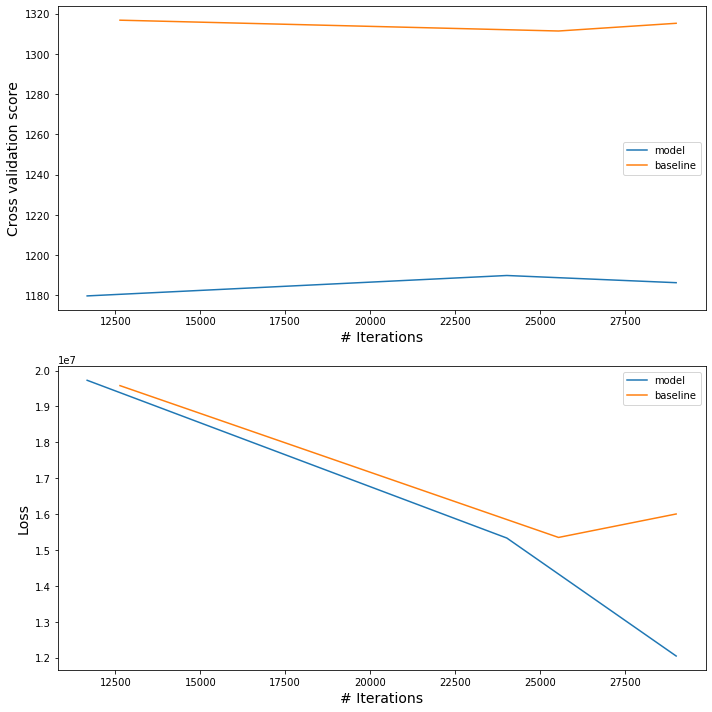

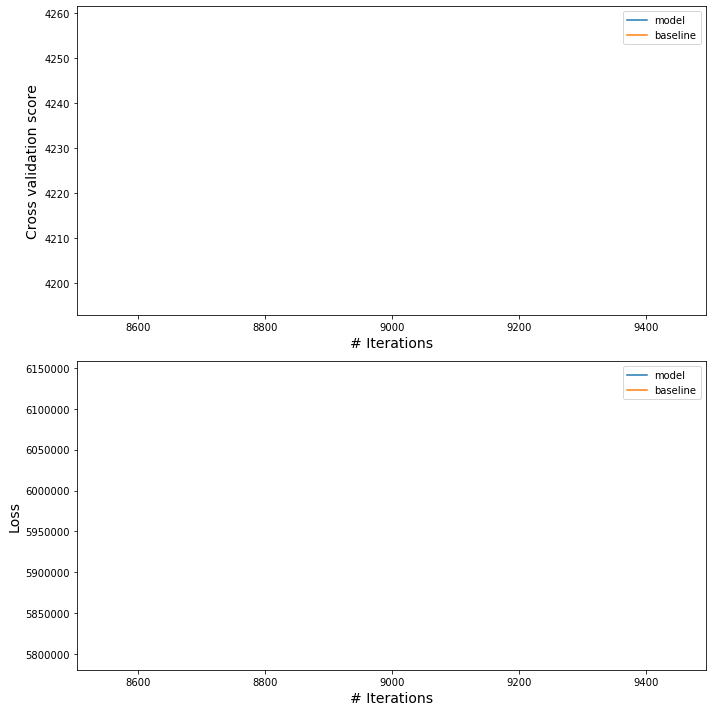

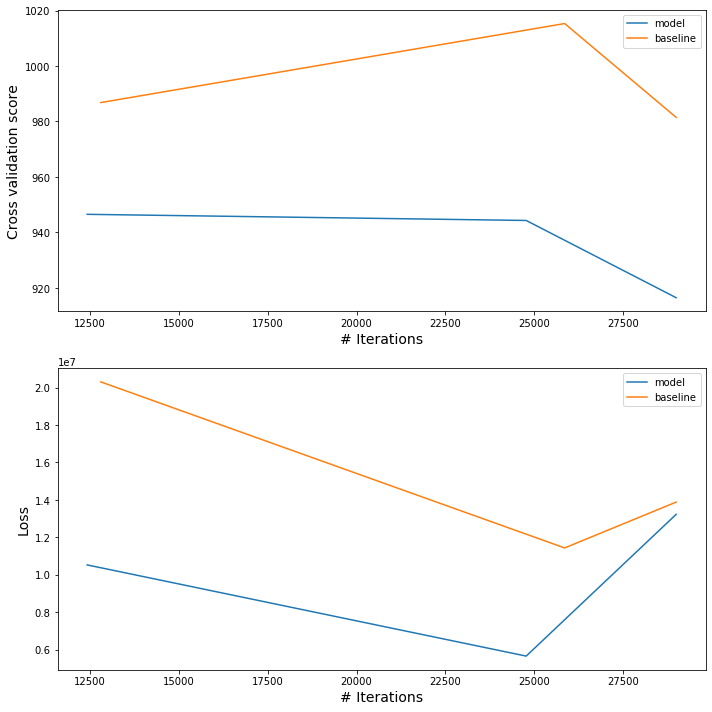

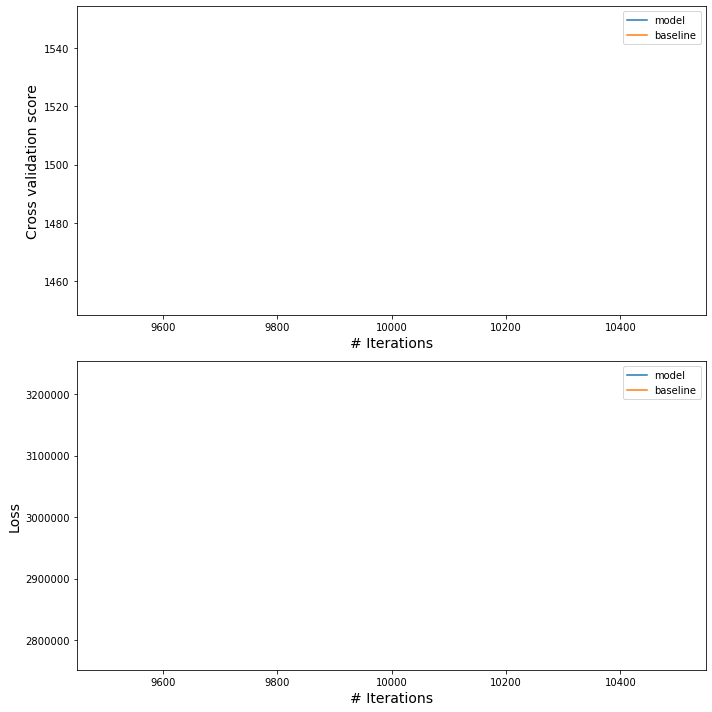

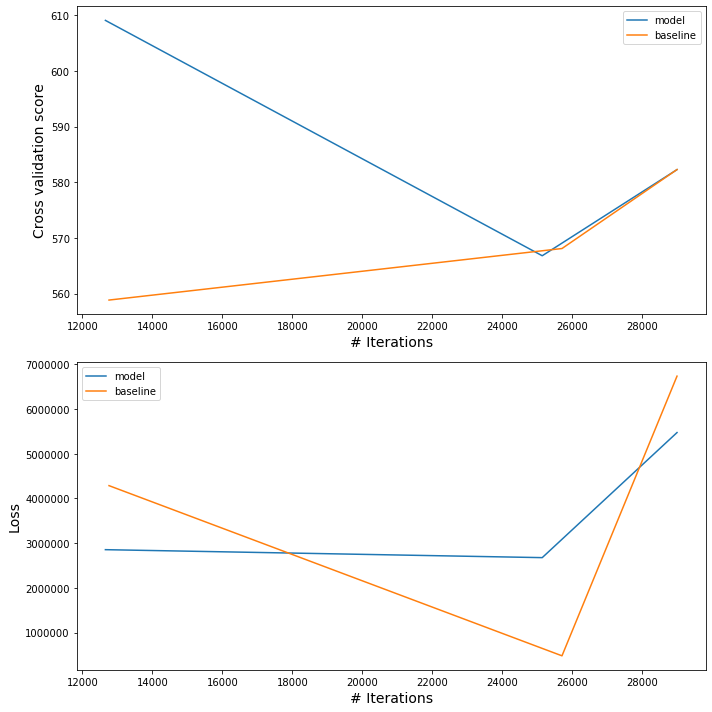

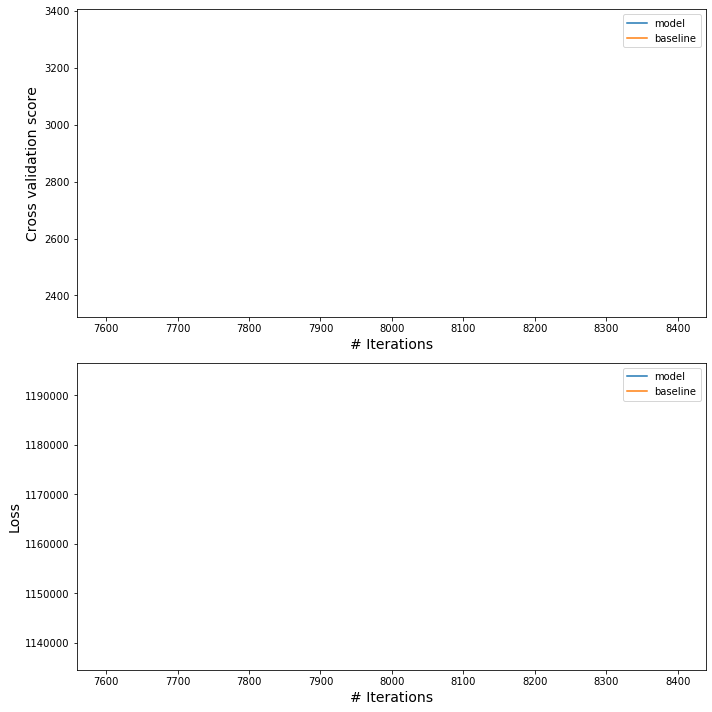

In [42]:
#Run/Import Songbird
out_folder= root_dir + "/intermediate_data/16S_milk_songbird/"
!mkdir -p $out_folder

md["milk"] = md.randomization.replace({"mother's own milk":"mom_milk",
                                      "Donor human milk":"donor_milk",
                                      "Formula":"formula"})


songbird_milk_dict = {}
formula= "C(study_delivery_mode, Treatment('LPI-Vaginal')) + age + C(milk, Treatment('formula'))"



for sample_type in ["Stool","Oral","Skin"]:
    songbird_milk_dict[sample_type] = {}
    for abx in [0,1]:
        songbird_milk_dict[sample_type][abx] = {}
        md_ss = md.query('sample_type==@sample_type & metadata_abx==@abx & qiita_study_id==11712')
        samples_keep = set(md_ss.index)
        temp_bt = genus_bt.filter(samples_keep, inplace=False)

        temp_qza = q2.Artifact.import_data('FeatureTable[Frequency]', temp_bt)
        temp_md_qza = q2.Metadata(md_ss)
        #temp_feature_md_qza = q2.Metadata(temp_feature_md)
        #Run songbird
        (temp_differentials,
         temp_regression_stats,
         temp_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula=formula)

        #Run null model (just sex)
        (null_differentials,
         null_regression_stats,
         null_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula="1")
        #Run qurro
        tmp_qurro = differential_plot(ranks= temp_differentials,
                                        table= temp_qza,
                                        sample_metadata=temp_md_qza,
                                       feature_metadata=tax_md_qza).visualization
        #Evaluate model fit
        tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                        baseline_stats = null_regression_stats).visualization
        #Add outputs to master dictionary
        songbird_milk_dict[sample_type][abx]["differentials"] = temp_differentials
        songbird_milk_dict[sample_type][abx]["regression_stats"] = temp_regression_stats
        songbird_milk_dict[sample_type][abx]["regression_biplot"] = temp_regression_biplot
        songbird_milk_dict[sample_type][abx]["qurro"] = tmp_qurro
        songbird_milk_dict[sample_type][abx]["model_fit"] = tmp_model_fit
        #Save outputs
        temp_differentials.save(out_folder + "{}_{}_differentials.qza".format(sample_type,abx))
        temp_regression_stats.save(out_folder + "{}_{}_regression_stats.qza".format(sample_type,abx))
        temp_regression_biplot.save(out_folder + "{}_{}_regression_biplot.qza".format(sample_type,abx))
        tmp_qurro.save(out_folder + "{}_{}_qurro.qzv".format(sample_type,abx))
        tmp_model_fit.save(out_folder + "{}_{}_model_fit.qzv".format(sample_type,abx))

        #Get q2
        q_square = get_q2(out_folder + "{}_{}_model_fit.qzv".format(sample_type,abx))
        songbird_milk_dict[sample_type][abx]["q_square"] = q_square
        print("{} {} q2:{}".format(sample_type, abx, q_square))
                                                    

________

# Permanova tables

In [76]:
#Get data
dm_df = dm.view(DistanceMatrix).to_data_frame()
keep_samples = set(dm_df.loc[dm_df.iloc[:,0].notna()].index)
dm_df = dm_df.loc[keep_samples,keep_samples]

#### Effect of Birth weight (LPI vs VLBW)
Only c-section

In [82]:
out_list = []
doty_md = md.query('delivery_mode=="c-section" & metadata_abx=="1"').copy()
for sample_type in ["Stool","Oral","Skin"]:
    temp_md = doty_md.query('sample_type==@sample_type').copy()
    sample_ss= set(temp_md.index) & keep_samples
    #Drop NAs
    dm_df_ss = dm_df.loc[sample_ss,sample_ss]
    if dm_df_ss.shape[0] < 6:
        continue
    temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
    pm = permanova(distance_matrix=temp_dm, grouping=temp_md, column="study_delivery_mode")
    pm["Delivery mode"] = "C-section"
    pm["Test factor"] = "Birth weight"
    pm["abx"] = "1"
    pm["sample_type"] = sample_type
    pm_df = pd.DataFrame(pm).transpose()
    out_list.append(pm_df)

In [83]:
birthweight_perm_df = pd.concat(out_list)
birthweight_perm_df = birthweight_perm_df.loc[:,["method name","Test factor","Delivery mode","sample_type","abx", "number of groups","test statistic","p-value"]]
birthweight_perm_df.columns= ["method name","Test factor","Delivery mode","sample_type","abx", "number of groups","pseudo-F","p-value"]
#birthweight_perm_df["BH p-value"] = multipletests(birthweight_perm_df["p-value"], method="bonferroni")[1]
birthweight_perm_df.to_csv(root_dir + "results/tables/20200609_16S_premanova_birth_weight.tsv",sep='\t')
birthweight_perm_df

,method name,Test factor,Delivery mode,sample_type,abx,number of groups,pseudo-F,p-value
PERMANOVA results,PERMANOVA,Birth weight,C-section,Stool,1,2,4.79318,0.006
PERMANOVA results,PERMANOVA,Birth weight,C-section,Oral,1,2,21.6451,0.001
PERMANOVA results,PERMANOVA,Birth weight,C-section,Skin,1,2,7.87101,0.001


#### Effect of antibiotics

In [85]:
out_list = []
for cohort in ["LPI-Vaginal","LPI-C-section"]:
    for sample_type in ["Stool","Oral","Skin"]:
        temp_md = md.query('study_delivery_mode==@cohort & sample_type==@sample_type').copy()
        sample_ss= set(temp_md.index) & keep_samples
        #Drop NAs
        dm_df_ss = dm_df.loc[sample_ss,sample_ss]
        if any(temp_md.abx_any_source.value_counts() < 20) or not len(dm_df_ss):
            print(cohort, sample_type)
            continue
        temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
        pm = permanova(distance_matrix=temp_dm, grouping=temp_md, column="metadata_abx")
        pm["Cohort"] = cohort
        pm["Test factor"] = "Antibiotics"
        pm["sample_type"] = sample_type
        pm_df = pd.DataFrame(pm).transpose()
        out_list.append(pm_df)

In [86]:
abx_perm_df = pd.concat(out_list)
abx_perm_df = abx_perm_df.loc[:,["method name","Test factor","Cohort","sample_type", "number of groups","test statistic","p-value"]]
abx_perm_df.columns= ["method name","Test factor","Cohort","sample_type", "number of groups","pseudo-F","p-value"]
#abx_perm_df["BH p-value"] = multipletests(abx_perm_df["p-value"], method="bonferroni")[1]
abx_perm_df.to_csv(root_dir + "results/tables/20200609_16S_premanova_abx.tsv",sep='\t')
abx_perm_df

,method name,Test factor,Cohort,sample_type,number of groups,pseudo-F,p-value
PERMANOVA results,PERMANOVA,Antibiotics,LPI-Vaginal,Stool,2,6.10064,0.002
PERMANOVA results,PERMANOVA,Antibiotics,LPI-Vaginal,Oral,2,6.22422,0.002
PERMANOVA results,PERMANOVA,Antibiotics,LPI-Vaginal,Skin,2,2.05749,0.116
PERMANOVA results,PERMANOVA,Antibiotics,LPI-C-section,Stool,2,6.76342,0.002
PERMANOVA results,PERMANOVA,Antibiotics,LPI-C-section,Oral,2,16.1996,0.001
PERMANOVA results,PERMANOVA,Antibiotics,LPI-C-section,Skin,2,6.04171,0.001


#### Effect of Delivery mode (c-section vs vaginal)
Only LPI

In [87]:
out_list = []

doty_md = md.query('qiita_study_id==11712').copy()
for sample_type in ["Stool","Oral","Skin"]:
    for abx in [1,0]:
        temp_md = doty_md.query('sample_type==@sample_type & metadata_abx == @abx').copy()
        sample_ss= set(temp_md.index) & keep_samples
        #Drop NAs
        dm_df_ss = dm_df.loc[sample_ss,sample_ss]
        if dm_df_ss.shape[0] < 6:
            continue
        
        temp_dm=DistanceMatrix(dm_df_ss, ids=dm_df_ss.index)
        pm = permanova(distance_matrix=temp_dm, grouping=temp_md, column="delivery_mode")
        pm["birth weight"] = "LPI"
        pm["Test factor"] = "delivery mode"
        pm["abx"] = abx
        pm["sample_type"] = sample_type
        pm_df = pd.DataFrame(pm).transpose()
        out_list.append(pm_df)

In [88]:
delivery_mode_perm_df = pd.concat(out_list)
delivery_mode_perm_df = delivery_mode_perm_df.loc[:,["method name","Test factor","birth weight","sample_type","abx", "number of groups","test statistic","p-value"]]
delivery_mode_perm_df.columns= ["method name","Test factor","birth weight","sample_type","abx", "number of groups","pseudo-F","p-value"]
#delivery_mode_perm_df["BH p-value"] = multipletests(delivery_mode_perm_df["p-value"], method="bonferroni")[1]
delivery_mode_perm_df.to_csv(root_dir + "results/tables/20200609_16S_premanova_delivery_mode.tsv",sep='\t')
delivery_mode_perm_df

,method name,Test factor,birth weight,sample_type,abx,number of groups,pseudo-F,p-value
PERMANOVA results,PERMANOVA,delivery mode,LPI,Stool,1,2,9.39677,0.001
PERMANOVA results,PERMANOVA,delivery mode,LPI,Stool,0,2,33.7248,0.001
PERMANOVA results,PERMANOVA,delivery mode,LPI,Oral,1,2,2.91342,0.067
PERMANOVA results,PERMANOVA,delivery mode,LPI,Oral,0,2,4.40691,0.012
PERMANOVA results,PERMANOVA,delivery mode,LPI,Skin,1,2,0.0958598,0.958
PERMANOVA results,PERMANOVA,delivery mode,LPI,Skin,0,2,5.41691,0.003


_______

# Stepwise RDA
Running RDA on deicode distances. Too much data to run on raw data

Format data

In [80]:
dm_df = dm.view(DistanceMatrix).to_data_frame()

In [81]:
!mkdir -p $root_dir/intermediate_data/ordistep
#Subset distance matrix (all body sites)
dm_df = dm.view(DistanceMatrix).to_data_frame()
keep_samples = set(dm_df.loc[dm_df.iloc[:,0].notna()].index)
dm_df = dm_df.loc[keep_samples,keep_samples]
dm_df_samples = set(dm_df.index)
dm_df= dm_df.sort_index()
dm_df.index.name="X.SampleID"
dm_df.to_csv(root_dir + "intermediate_data/ordistep/rda_deicode_data_all.tsv",sep='\t')

#Subset metadata (all body sites)
rda_md = md.query('index in @dm_df_samples').loc[:,["sample_type","metadata_abx","delivery_mode","qiita_study_id","age","randomization"]]
rda_md.index.name="X.SampleID"
rda_md = rda_md.sort_index()
rda_md.to_csv(root_dir + "intermediate_data/ordistep/rda_md_all.tsv",sep='\t')

assert(all([x==y for x,y in zip(rda_md.index,dm_df.index )]))


#Subset by body site
for sample_type in ["Stool","Oral","Skin"]:
    rda_md_ss = rda_md.query('sample_type==@sample_type')
    rda_md_ss = rda_md_ss.drop(columns=["sample_type"])
    rda_md_ss.to_csv(root_dir + "/intermediate_data/ordistep/rda_md_{}.tsv".format(sample_type), sep='\t')
    sample_ss = list(rda_md_ss.index)
    dm_df_ss = dm_df.loc[sample_ss,sample_ss]
    dm_df_ss.to_csv(root_dir + "intermediate_data/ordistep/rda_deicode_data_{}.tsv".format(sample_type),sep='\t')
    assert(all([x==y for x,y in zip(rda_md_ss.index,dm_df_ss.index )]))

Run stepwise rda

In [82]:
%%script bash 

source ~/.bash_profile
conda activate qiime2-2020.2

root_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/ordistep
Rfile=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks/utils/stepwise-rda.R

declare -A datasets=( [all]=$root_dir/rda_deicode_data_all.tsv
                     [Stool]=$root_dir/rda_deicode_data_Stool.tsv
                     [Oral]=$root_dir/rda_deicode_data_Oral.tsv
                    [Skin]=$root_dir/rda_deicode_data_Skin.tsv )

declare -A metadatas=( [all]=$root_dir/rda_md_all.tsv
                     [Stool]=$root_dir/rda_md_Stool.tsv
                     [Oral]=$root_dir/rda_md_Oral.tsv
                    [Skin]=$root_dir/rda_md_Skin.tsv )


for subset in {all,Stool,Oral,Skin}
    do
    out_file=$root_dir/deicode_ordistep_results_${subset}.tsv
    Rscript $Rfile ${datasets[$subset]} ${metadatas[$subset]} $out_file
    done


R version 3.5.1 (2018-07-02) 
Call: rda(formula = Y_16S ~ 1, data = X_16S)

              Inertia Rank
Total           675.9     
Unconstrained   675.9  830
Inertia is variance 

Eigenvalues for unconstrained axes:
  PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8 
361.8 168.2 106.6  26.7   4.0   1.8   1.3   1.3 
(Showing 8 of 830 unconstrained eigenvalues)

Call: rda(formula = Y_16S ~ sample_type + metadata_abx + delivery_mode
+ qiita_study_id + age + randomization, data = X_16S)

               Inertia Proportion Rank
Total         675.9280     1.0000     
Constrained   232.7004     0.3443    8
Unconstrained 443.2275     0.6557  877
Inertia is variance 

Eigenvalues for constrained axes:
  RDA1   RDA2   RDA3   RDA4   RDA5   RDA6   RDA7   RDA8 
149.62  56.89  24.35   1.41   0.33   0.08   0.02   0.01 

Eigenvalues for unconstrained axes:
   PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8 
222.47 112.71  75.60  20.85   3.20   1.76   1.30   1.23 
(Showing 8 of 877 unconstrained eigenv

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6


Format and save final tables

In [84]:
ordistep_results_files= !ls $root_dir/intermediate_data/ordistep/deicode_ordistep_results* 
for file in ordistep_results_files:
    file_name=file.split('/')[-1]
    dat = pd.read_csv(file, sep='\t')
    dat.columns = ["Factor","R2.adj","Df","AIC", "F", "Pr(>F)"]
    dat['R2.adj'] = [dat['R2.adj'].values[0]] + list(dat['R2.adj'].diff().values[1:])
    dat.to_csv(root_dir + "/results/tables/16S_" + file_name, sep='\t')
    print(file.split('_')[-1].split('.')[0])
    print(dat)

all
             Factor    R2.adj   Df          AIC           F  Pr(>F)
0     + sample_type  0.169973  2.0  5952.996837   97.144397   0.002
1    + metadata_abx  0.094643  1.0  5840.191595  121.590890   0.002
2             + age  0.043022  1.0  5784.520231   59.160899   0.002
3  + qiita_study_id  0.015945  1.0  5763.613200   23.040427   0.002
4   + delivery_mode  0.013844  1.0  5745.168269   20.514978   0.002
5   <All variables>  0.001207  NaN          NaN         NaN     NaN
Oral
             Factor    R2.adj   Df          AIC           F  Pr(>F)
0    + metadata_abx  0.249423  1.0  1605.936445  104.347789   0.002
1             + age  0.099618  1.0  1562.501127   48.439921   0.002
2  + qiita_study_id  0.044044  1.0  1541.631798   23.424130   0.002
3   + delivery_mode  0.004755  1.0  1540.163355    3.431900   0.024
4   <All variables>  0.002682  NaN          NaN         NaN     NaN
Skin
             Factor    R2.adj   Df          AIC          F  Pr(>F)
0             + age  0.113785  1.0 

In [189]:
md_add_df = md.groupby("host_subject_id").agg({"abx":"first","maternal_any_abx":"first"})
jdf = jdf.merge(md_add_df, left_on="host_subject_id", right_on="host_subject_id")

def make_abx_category(row):
    "With maternal antibiotics"
    if row.study == "stillwell":
        return(1)
    abx=int(row.abx)
    mabx=int(row.maternal_any_abx)
    age=int(row.age)
    if not abx and not mabx:
        return(0)
    elif not abx and mabx:
        return(2)
    elif abx and abx <= age:
        return(1)
    elif abx and abx>age and mabx:
        return(2)
    elif abx and abx>age and not mabx:
        return(0)
    else:
        raise ValueError(row)
def make_abx_category2(row):
    "Without maternal antibiotics"
    if row.study == "stillwell":
        return(1)
    abx=int(row.abx)
    age=int(row.age)
    if not abx:
        return(0)
    elif abx and abx <= age:
        return(1)
    else:
        return(0)
jdf["abx_category"] = jdf.apply(axis=1, func=make_abx_category2)